# Flight Data Preprocessing

We perform the initial data preparation step for our flight delay prediction project. It handles the crucial task of merging multiple Bureau of Transportation Statistics (BTS) flight data files into a single consolidated dataset that we can use for our analysis and modeling.

## What this code does:

1. **File Discovery and Loading**: Searches for all BTS flight data CSV files matching a specified pattern (T_ONTIME_REPORTING_*.csv).

2. **Data Consolidation**: Merges multiple monthly flight data files into a single comprehensive dataset.

3. **Data Validation and Cleaning**:
   - Checks for consistency in column structures across files
   - Identifies and handles common columns if files have different structures
   - Validates key fields (FL_DATE, OP_UNIQUE_CARRIER, ORIGIN, DEST)
   - Converts date fields to proper datetime format
   - Detects and reports duplicate entries

4. **Data Enrichment**: Adds source file information to each record for traceability.

5. **Performance Optimization**: Implements progress tracking and timing metrics to monitor the processing of large datasets.

6. **Basic Exploratory Analysis**: Generates initial statistics on the merged dataset:
   - Date range coverage
   - Flight distribution by carrier
   - Overall delay rates
   - Monthly delay patterns


In [1]:
import pandas as pd
import os
import glob
import time

def merge_flight_data_files(file_pattern, output_file):
    print(f"Searching for files matching pattern: {file_pattern}")
    
    all_files = glob.glob(file_pattern)
    
    if not all_files:
        print(f"No files found matching pattern: {file_pattern}")
        return None
    
    print(f"Found {len(all_files)} files to merge:")
    for file in all_files:
        print(f"  - {os.path.basename(file)}")
    
    all_dataframes = []
    total_rows = 0
    
    for file in all_files:
        start_time = time.time()
        print(f"\nProcessing {os.path.basename(file)}...")
        
        try:
            df = pd.read_csv(file, low_memory=False)
            
            month_name = os.path.basename(file).split('_')[3].split('.')[0]
            print(f"  Identified month: {month_name}")
            
            df['SOURCE_FILE'] = os.path.basename(file)
            
            all_dataframes.append(df)
            
            file_rows = len(df)
            total_rows += file_rows
            
            elapsed = time.time() - start_time
            print(f"  Read {file_rows} rows in {elapsed:.2f} seconds")
            print(f"  Columns: {len(df.columns)}")
            
        except Exception as e:
            print(f"  Error processing {file}: {str(e)}")
    
    if not all_dataframes:
        print("No data was successfully loaded. Check file formats.")
        return None
    
    column_sets = [set(df.columns) for df in all_dataframes]
    all_same_columns = all(column_sets[0] == column_set for column_set in column_sets)
    
    if not all_same_columns:
        print("\nWarning: Not all files have the same columns.")
        
        common_columns = set.intersection(*column_sets)
        print(f"Found {len(common_columns)} common columns across all files.")
        
        for i, df in enumerate(all_dataframes):
            all_dataframes[i] = df[list(common_columns)]
    
    print(f"\nMerging {len(all_dataframes)} dataframes...")
    start_time = time.time()
    merged_data = pd.concat(all_dataframes, ignore_index=True)
    elapsed = time.time() - start_time
    print(f"Merged in {elapsed:.2f} seconds")
    
    print("\nPerforming basic validation...")
    
    key_columns = ['FL_DATE', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']
    for col in key_columns:
        if col in merged_data.columns:
            missing = merged_data[col].isnull().sum()
            if missing > 0:
                print(f"  Warning: {missing} missing values in {col} ({missing/len(merged_data)*100:.2f}%)")
    
    if 'FL_DATE' in merged_data.columns:
        merged_data['FL_DATE'] = pd.to_datetime(merged_data['FL_DATE'])
        
        min_date = merged_data['FL_DATE'].min()
        max_date = merged_data['FL_DATE'].max()
        print(f"Date range: {min_date} to {max_date}")
        
        year_2024 = (merged_data['FL_DATE'].dt.year == 2024).all()
        if not year_2024:
            years = merged_data['FL_DATE'].dt.year.unique()
            print(f"  Warning: Data contains years other than 2024: {sorted(years)}")
    
    duplicate_count = merged_data.duplicated().sum()
    if duplicate_count > 0:
        print(f"  Warning: Found {duplicate_count} duplicate rows")
    
    print(f"\nSaving merged data to {output_file}...")
    start_time = time.time()
    merged_data.to_csv(output_file, index=False)
    elapsed = time.time() - start_time
    print(f"Saved in {elapsed:.2f} seconds")
    
    print(f"\nSuccessfully merged {len(all_dataframes)} files into {output_file}")
    print(f"Total rows: {len(merged_data)}")
    print(f"Total columns: {len(merged_data.columns)}")
    
    return merged_data

merged_data = merge_flight_data_files("T_ONTIME_REPORTING_*.csv", "BTS_FLIGHT_DATA_2024_ALL.csv")

if merged_data is not None:
    print("\nSummary Statistics:")
    
    if 'OP_UNIQUE_CARRIER' in merged_data.columns:
        carrier_counts = merged_data['OP_UNIQUE_CARRIER'].value_counts()
        print("\nFlights by Carrier:")
        for carrier, count in carrier_counts.head(10).items():
            print(f"  {carrier}: {count} flights")
        
        if len(carrier_counts) > 10:
            print(f"  ...and {len(carrier_counts) - 10} more carriers")
    
    if 'DEP_DEL15' in merged_data.columns:
        delay_rate = merged_data['DEP_DEL15'].mean() * 100
        print(f"\nOverall Delay Rate: {delay_rate:.2f}%")
        
        if 'FL_DATE' in merged_data.columns:
            merged_data['MONTH'] = merged_data['FL_DATE'].dt.month
            monthly_delays = merged_data.groupby('MONTH')['DEP_DEL15'].mean() * 100
            
            print("\nDelay Rate by Month:")
            for month, rate in monthly_delays.items():
                month_name = {
                    1: 'January', 2: 'February', 3: 'March', 4: 'April',
                    5: 'May', 6: 'June', 7: 'July', 8: 'August',
                    9: 'September', 10: 'October', 11: 'November', 12: 'December'
                }.get(month, f"Month {month}")
                
                print(f"  {month_name}: {rate:.2f}%")

Searching for files matching pattern: T_ONTIME_REPORTING_*.csv
Found 6 files to merge:
  - T_ONTIME_REPORTING_AUG.csv
  - T_ONTIME_REPORTING_SEP.csv
  - T_ONTIME_REPORTING_OCT.csv
  - T_ONTIME_REPORTING_JUL.csv
  - T_ONTIME_REPORTING_NOV.csv
  - T_ONTIME_REPORTING_DEC.csv

Processing T_ONTIME_REPORTING_AUG.csv...
  Identified month: AUG
  Read 619025 rows in 1.72 seconds
  Columns: 40

Processing T_ONTIME_REPORTING_SEP.csv...
  Identified month: SEP
  Read 582622 rows in 1.61 seconds
  Columns: 40

Processing T_ONTIME_REPORTING_OCT.csv...
  Identified month: OCT
  Read 615497 rows in 1.64 seconds
  Columns: 40

Processing T_ONTIME_REPORTING_JUL.csv...
  Identified month: JUL
  Read 634613 rows in 1.73 seconds
  Columns: 40

Processing T_ONTIME_REPORTING_NOV.csv...
  Identified month: NOV
  Read 575404 rows in 1.56 seconds
  Columns: 40

Processing T_ONTIME_REPORTING_DEC.csv...
  Identified month: DEC
  Read 590581 rows in 1.60 seconds
  Columns: 40

Merging 6 dataframes...
Merged in 0.

/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_2944/419240305.py:78: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['FL_DATE'] = pd.to_datetime(merged_data['FL_DATE'])


Date range: 2024-07-01 00:00:00 to 2024-12-31 00:00:00

Saving merged data to BTS_FLIGHT_DATA_2024_ALL.csv...
Saved in 22.23 seconds

Successfully merged 6 files into BTS_FLIGHT_DATA_2024_ALL.csv
Total rows: 3617742
Total columns: 40

Summary Statistics:

Flights by Carrier:
  WN: 706659 flights
  DL: 520646 flights
  AA: 496269 flights
  OO: 394649 flights
  UA: 391628 flights
  YX: 158683 flights
  MQ: 143616 flights
  NK: 129141 flights
  AS: 128689 flights
  OH: 122467 flights
  ...and 5 more carriers

Overall Delay Rate: 19.65%

Delay Rate by Month:
  July: 29.52%
  August: 23.07%
  September: 15.08%
  October: 13.61%
  November: 14.41%
  December: 21.65%


# Flight Data Consolidation Results

This analysis processed 6 months of Bureau of Transportation Statistics (BTS) flight data from July through December 2024, merging over 3.6 million flight records.

## Data Processing Metrics:
- **Total Records**: 3,617,742 flights
- **Time Period**: July 1 - December 31, 2024
- **Processing Time**: Fast parsing (1.5-1.7 seconds per month) with efficient merging (0.19 seconds)

## Carrier Analysis:
- **Top Carriers**: Southwest (WN) led with 706,659 flights, followed by Delta (DL) with 520,646 and American (AA) with 496,269
- **Market Diversity**: 15 different carriers represented in the dataset

## Delay Analysis:
- **Overall Delay Rate**: 19.65% of flights were delayed (15+ minutes)
- **Seasonal Patterns**: 
  - Highest delays: July (29.52%) and August (23.07%)
  - Lowest delays: October (13.61%) and September (15.08%)
  - Year-end increase: December (21.65%) showed significant worsening compared to fall months


In [2]:
import pandas as pd

merged_data = pd.read_csv('BTS_FLIGHT_DATA_2024_ALL.csv',low_memory=False )

In [3]:
merged_data.shape

(3617742, 40)

In [4]:
merged_data.columns

Index(['YEAR', 'MONTH', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER',
       'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME',
       'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR',
       'DEST_STATE_NM', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15',
       'DEP_DELAY_GROUP', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW',
       'ARR_DEL15', 'ARR_DELAY_GROUP', 'CANCELLED', 'CANCELLATION_CODE',
       'DIVERTED', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP',
       'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
       'LATE_AIRCRAFT_DELAY', 'SOURCE_FILE'],
      dtype='object')

In [5]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3617742 entries, 0 to 3617741
Data columns (total 40 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   FL_DATE              object 
 3   OP_UNIQUE_CARRIER    object 
 4   OP_CARRIER           object 
 5   OP_CARRIER_FL_NUM    float64
 6   ORIGIN_AIRPORT_ID    int64  
 7   ORIGIN               object 
 8   ORIGIN_CITY_NAME     object 
 9   ORIGIN_STATE_ABR     object 
 10  ORIGIN_STATE_NM      object 
 11  DEST_AIRPORT_ID      int64  
 12  DEST_AIRPORT_SEQ_ID  int64  
 13  DEST                 object 
 14  DEST_CITY_NAME       object 
 15  DEST_STATE_ABR       object 
 16  DEST_STATE_NM        object 
 17  DEP_TIME             float64
 18  DEP_DELAY            float64
 19  DEP_DELAY_NEW        float64
 20  DEP_DEL15            float64
 21  DEP_DELAY_GROUP      float64
 22  ARR_TIME             float64
 23  ARR_DELAY            float64
 24

In [4]:
flight_data = merged_data.copy()

# Airport Coordinate Data Collection

We retrieve geographical coordinate data for airports worldwide from the OpenFlights dataset, which will be essential for our flight delay prediction model. Geographical information allows us to calculate distances between airports and incorporate weather data based on location.

## What this code does:

1. **Data Source**: Fetches airport data directly from the OpenFlights GitHub repository, which contains comprehensive information about airports worldwide.

2. **Data Processing**:
   - Assigns proper column names to the raw dataset
   - Filters for airports with valid IATA codes (the 3-letter codes used in flight data)
   - Removes entries with missing or invalid IATA identifiers

3. **Data Validation**: Ensures we only keep airports that can be matched with our flight dataset by validating IATA code format.

4. **Data Persistence**: Saves the filtered airport dataset to a CSV file for future reference and use in subsequent analysis steps.

5. **Error Handling**: Implements error handling to gracefully manage potential connection issues or data format changes.


In [2]:
import pandas as pd
import numpy as np

def fetch_airport_coordinates():
    print("Fetching airport coordinates from OpenFlights...")
    
    airport_columns = ['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 
                       'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 
                       'Tz database time zone', 'Type', 'Source']
    
    url = "https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
    
    try:
        airports_df = pd.read_csv(url, header=None, names=airport_columns)
        print(f"Fetched data for {len(airports_df)} airports")
    
        airports_df = airports_df[airports_df['IATA'].notna() & (airports_df['IATA'] != '\\N') & (airports_df['IATA'].str.len() == 3)]
        
        print(f"Filtered to {len(airports_df)} airports with valid IATA codes")
        
        airports_df.to_csv('openflights_airports.csv', index=False)
        print("Saved airport data to openflights_airports.csv")
        
        return airports_df
    
    except Exception as e:
        print(f"Error fetching airport data: {e}")
        return None

airports_df = fetch_airport_coordinates()

Fetching airport coordinates from OpenFlights...
Fetched data for 7698 airports
Filtered to 6072 airports with valid IATA codes
Saved airport data to openflights_airports.csv


# Data Exploration and Airport Code Verification

We examine our flight dataset to verify that we have the necessary airport code fields (ORIGIN and DEST) that will be used to join with our OpenFlights airport coordinate data. The verification process confirms the structure of our flight data and ensures that the airport codes are in a format that can be properly matched with the geographical coordinates we've collected. This verification step is crucial before proceeding with distance calculations and feature engineering for our flight delay prediction model.

Our exploration revealed a robust dataset containing 3,617,742 flight records with 40 columns. The data includes essential fields such as origin and destination airport codes (ORIGIN and DEST), which are in the standard three-letter IATA format (e.g., HPN, DTW, ATL) that matches our OpenFlights data structure. Additionally, we found extensive flight information including departure and arrival times, delay metrics (DEP_DELAY, ARR_DELAY), delay classifications (DEP_DEL15, ARR_DEL15), cancellation data, and delay attribution categories (CARRIER_DELAY, WEATHER_DELAY, etc.). This comprehensive dataset provides an excellent foundation for our flight delay prediction model.

In [5]:
print(f"Loaded flight data: {len(flight_data)} rows, {flight_data.shape[1]} columns")

print("\nColumn names in flight data:")
print(flight_data.columns.tolist())

print("\nSample of ORIGIN values:")
print(flight_data['ORIGIN'].head(10))

if 'DEST' in flight_data.columns:
    print("\nSample of DEST values:")
    print(flight_data['DEST'].head(10))
else:
    print("\nNo column named 'DEST' found. Checking alternative columns...")

    possible_dest_columns = [col for col in flight_data.columns if 'DEST' in col]
    print(f"Possible destination columns: {possible_dest_columns}")
    
    if possible_dest_columns:
        for col in possible_dest_columns:
            print(f"\nSample of {col} values:")
            print(flight_data[col].head(10))

Loaded flight data: 3617742 rows, 40 columns

Column names in flight data:
['YEAR', 'MONTH', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_NM', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'SOURCE_FILE']

Sample of ORIGIN values:
0    HPN
1    DTW
2    RIC
3    ROC
4    CHO
5    CLT
6    IND
7    PWM
8    CVG
9    MOB
Name: ORIGIN, dtype: object

Sample of DEST values:
0    ATL
1    ORF
2    JFK
3    DTW
4    ATL
5    LGA
6    JFK
7    LGA
8    DTW
9    ATL
Name: DEST, dtype: object


# Data Enrichment with Airport Coordinates

We enhanced our flight dataset by merging geographical coordinates from the OpenFlights database with our flight records. The integration process joins origin and destination airport information using IATA codes as the common identifier. This geographic enrichment is essential for:

1. Calculating accurate flight distances
2. Enabling weather data integration based on precise airport locations
3. Facilitating timezone calculations for more accurate delay metrics
4. Supporting visualization of flight routes on maps

The process successfully integrated coordinates for both origin and destination airports. We also identified and manually added coordinates for two airports (XWA: Williston Basin International Airport and EAR: Kearney Regional Airport) that were present in our flight data but missing from the OpenFlights database.

The enrichment process was completed with no missing coordinates for either origin or destination airports, indicating successful data integration.

In [6]:
def enrich_flight_data_with_coordinates(flight_df, airports_df):

    print("Enriching flight data with airport coordinates...")
    missing_airports = pd.DataFrame([
        {'IATA': 'XWA', 'Name': 'Williston Basin International Airport', 
         'City': 'Williston', 'Country': 'United States', 
         'Latitude': 48.2595, 'Longitude': -103.7519, 
         'Altitude': 1982, 'Timezone': -6, 'Tz database time zone': 'America/Denver'},

        {'IATA': 'EAR', 'Name': 'Kearney Regional Airport', 
         'City': 'Kearney', 'Country': 'United States', 
         'Latitude': 40.7270, 'Longitude': -99.0068, 
         'Altitude': 2131, 'Timezone': -6, 'Tz database time zone': 'America/Chicago'}
    ])
    
    airports_df = pd.concat([airports_df, missing_airports], ignore_index=True)
    print(f"Added missing airports (XWA, EAR) to the airport database")
    
    airport_coords = airports_df[['IATA', 'Latitude', 'Longitude', 'Name', 'City', 
                                 'Country', 'Altitude', 'Timezone', 'Tz database time zone']]
    
    origin_coords = airport_coords.copy()
    origin_coords.columns = ['ORIGIN', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE', 'ORIGIN_AIRPORT_NAME',
                           'ORIGIN_CITY', 'ORIGIN_COUNTRY', 'ORIGIN_ALTITUDE', 'ORIGIN_TIMEZONE', 
                           'ORIGIN_TZ_DATABASE']
    
    print("Merging origin airport information...")
    enriched_df = pd.merge(
        flight_df,
        origin_coords,
        on='ORIGIN',
        how='left'
    )
    
    missing_origins = enriched_df['ORIGIN_LATITUDE'].isna().sum()
    if missing_origins > 0:
        missing_pct = (missing_origins / len(enriched_df)) * 100
        print(f"Warning: {missing_origins} rows ({missing_pct:.2f}%) have missing origin coordinates")
        
        missing_airports = enriched_df[enriched_df['ORIGIN_LATITUDE'].isna()]['ORIGIN'].value_counts().head(10)
        print("Top missing origin airports:")
        print(missing_airports)
    
    enriched_df.to_csv('flight_data_with_origin_coordinates.csv', index=False)
    print("Saved intermediate data with origin coordinates")
    
    dest_coords = airport_coords.copy()
    dest_coords.columns = ['DEST', 'DEST_LATITUDE', 'DEST_LONGITUDE', 'DEST_AIRPORT_NAME',
                          'DEST_CITY', 'DEST_COUNTRY', 'DEST_ALTITUDE', 'DEST_TIMEZONE', 
                          'DEST_TZ_DATABASE']
    
    print(f"Merging destination airport information using column 'DEST'...")
    enriched_df = pd.merge(
        enriched_df,
        dest_coords,
        on='DEST',
        how='left'
    )

    missing_dests = enriched_df['DEST_LATITUDE'].isna().sum()
    if missing_dests > 0:
        missing_pct = (missing_dests / len(enriched_df)) * 100
        print(f"Warning: {missing_dests} rows ({missing_pct:.2f}%) have missing destination coordinates")
        
        missing_airports = enriched_df[enriched_df['DEST_LATITUDE'].isna()]['DEST'].value_counts().head(10)
        print(f"Top missing DEST airports:")
        print(missing_airports)
    
    enriched_df.to_csv('flight_data_with_coordinates.csv', index=False)
    print("Saved enriched flight data with coordinates")
    
    return enriched_df

enriched_flight_data = enrich_flight_data_with_coordinates(flight_data, airports_df)

Enriching flight data with airport coordinates...
Added missing airports (XWA, EAR) to the airport database
Merging origin airport information...
Saved intermediate data with origin coordinates
Merging destination airport information using column 'DEST'...
Saved enriched flight data with coordinates


### Data Dimension Comparison: Enrichment Added 16 New Geographic Features to Dataset (3,617,742 rows × 56 columns)

In [8]:
flight_data.shape

(3617742, 40)

In [9]:
enriched_flight_data.shape

(3617742, 56)

### Missing Value Analysis: Complete Geographic Data Successfully Joined, Various Delay-Related Fields Have Missing Values

In [10]:
enriched_flight_data.isna().sum()

YEAR                         0
MONTH                        0
FL_DATE                      0
OP_UNIQUE_CARRIER            0
OP_CARRIER                   0
OP_CARRIER_FL_NUM            1
ORIGIN_AIRPORT_ID            0
ORIGIN                       0
ORIGIN_CITY_NAME             0
ORIGIN_STATE_ABR             0
ORIGIN_STATE_NM              0
DEST_AIRPORT_ID              0
DEST_AIRPORT_SEQ_ID          0
DEST                         0
DEST_CITY_NAME               0
DEST_STATE_ABR               0
DEST_STATE_NM                0
DEP_TIME                 45898
DEP_DELAY                46011
DEP_DELAY_NEW            46011
DEP_DEL15                46011
DEP_DELAY_GROUP          46011
ARR_TIME                 48344
ARR_DELAY                55960
ARR_DELAY_NEW            55960
ARR_DEL15                55960
ARR_DELAY_GROUP          55960
CANCELLED                    0
CANCELLATION_CODE      3570093
DIVERTED                     0
AIR_TIME                 55960
FLIGHTS                      0
DISTANCE

In [7]:
pip install pandas numpy scikit-learn tqdm

Note: you may need to restart the kernel to use updated packages.


# Data Preprocessing and Optimization

We implement memory-efficient data processing for our large flight dataset (3.6+ million records). The processing is done in chunks to handle the significant memory requirements and includes several critical operations:

## Key Data Processing Steps:

1. **Memory Optimization**: Implements aggressive memory reduction by downcasting numeric data types based on their value ranges (e.g., converting int64 to int8/int16 where possible).

2. **Handling Missing Values**:
   - Creates binary indicators for missing delay data
   - Intelligently imputes time fields using carrier and route-specific medians
   - Properly handles missing values in cancelled flights

3. **Feature Engineering**:
   - Creates a unified target variable (`IS_DELAYED`) based on departure and arrival delay flags
   - Adds informative flags for missing delay information
   - Handles delay cause reporting

4. **Data Integrity**: Ensures consistent delay classifications by updating delay flags based on actual delay values

## Technical Implementation:

We processed the dataset in 50,000-row chunks to manage memory constraints, combining the processed chunks at the end. This chunked processing approach enabled us to handle the full 3.6 million flight records efficiently, expanding the dataset from 56 to 60 columns by adding engineered features while maintaining memory efficiency.

In [11]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import gc
from tqdm import tqdm

def reduce_mem_usage(df):
    print("Reducing memory usage...")
    for col in tqdm(df.columns):
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    return df

def preprocess_flight_data(file_path, chunksize=100000):
    print("Processing flight data in chunks...")
    
    processed_chunks = []
    
    for chunk in tqdm(pd.read_csv(file_path, chunksize=chunksize), desc="Processing chunks"):
        chunk = reduce_mem_usage(chunk)
        
        chunk['DEP_DELAY_MISSING'] = chunk['DEP_DELAY'].isna().astype(np.int8)
        chunk['ARR_DELAY_MISSING'] = chunk['ARR_DELAY'].isna().astype(np.int8)
        
        cancelled_mask = chunk['CANCELLED'] == 1
        delay_columns = ['DEP_DELAY', 'DEP_DELAY_NEW', 'ARR_DELAY', 'ARR_DELAY_NEW', 
                         'DEP_DEL15', 'ARR_DEL15', 'DEP_DELAY_GROUP', 'ARR_DELAY_GROUP']
        
        for col in delay_columns:
            if col in chunk.columns:
                chunk.loc[cancelled_mask, col] = np.nan
        
        delay_cause_columns = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 
                              'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
        
        if all(col in chunk.columns for col in delay_cause_columns):
            chunk['DELAY_CAUSE_REPORTED'] = chunk[delay_cause_columns].notna().any(axis=1).astype(np.int8)
            
        for col in ['DEP_TIME', 'ARR_TIME']:
            if col in chunk.columns:
                impute_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']
                if all(c in chunk.columns for c in impute_cols):
                    chunk[col] = chunk.groupby(impute_cols)[col].transform(
                        lambda x: x.fillna(x.median()) if not x.median() != x.median() else x.fillna(0)
                    )
                else:
                    chunk[col] = chunk[col].fillna(chunk[col].median())
        
        not_cancelled = chunk['CANCELLED'] == 0
        
        for col in ['DEP_DELAY', 'ARR_DELAY']:
            if col in chunk.columns:
                missing_mask = chunk[col].isna() & not_cancelled
                chunk.loc[missing_mask, col] = 0.0
        
        for base, flag in [('DEP_DELAY', 'DEP_DEL15'), ('ARR_DELAY', 'ARR_DEL15')]:
            if base in chunk.columns and flag in chunk.columns:
                chunk.loc[chunk[base] < 15, flag] = 0
                chunk.loc[chunk[base] >= 15, flag] = 1
        
        if 'DEP_DEL15' in chunk.columns and 'ARR_DEL15' in chunk.columns:
            chunk['IS_DELAYED'] = ((chunk['DEP_DEL15'] == 1) | (chunk['ARR_DEL15'] == 1)).astype(np.int8)
        
        processed_chunks.append(chunk)
        
        gc.collect()
    
    print("Combining processed chunks...")
    df_processed = pd.concat(processed_chunks, ignore_index=True)
    
    gc.collect()
    
    print(f"Final dataset shape: {df_processed.shape}")
    return df_processed

df_processed = preprocess_flight_data('flight_data_with_coordinates.csv', chunksize=50000)
df_processed.to_csv('processed_flight_data.csv', index=False)

Processing flight data in chunks...


Processing chunks: 0it [00:00, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6151.78it/s]
Processing chunks: 1it [00:01,  1.76s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6331.37it/s]
Processing chunks: 2it [00:03,  1.72s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7015.77it/s]
Processing chunks: 3it [00:04,  1.62s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6876.11it/s]
Processing chunks: 4it [00:06,  1.61s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7000.92it/s]
Processing chunks: 5it [00:08,  1.60s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7446.61it/s]
Processing chunks: 6it [00:09,  1.55s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6659.51it/s]
Processing chunks: 7it [00:11,  1.53s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7066.22it/s]
Processing chunks: 8it [00:12,  1.54s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6829.92it/s]
Processing chunks: 9it [00:14,  1.51s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7398.76it/s]
Processing chunks: 10it [00:15,  1.51s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6999.05it/s]
Processing chunks: 11it [00:17,  1.50s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7053.70it/s]
Processing chunks: 12it [00:18,  1.51s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7081.34it/s]
Processing chunks: 13it [00:20,  1.51s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7178.52it/s]
Processing chunks: 14it [00:21,  1.47s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7206.27it/s]
Processing chunks: 15it [00:22,  1.47s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7435.77it/s]
Processing chunks: 16it [00:24,  1.49s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6984.27it/s]
Processing chunks: 17it [00:25,  1.46s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7179.39it/s]
Processing chunks: 18it [00:27,  1.48s/it]

Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6832.50it/s]
Processing chunks: 19it [00:28,  1.48s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7122.14it/s]
Processing chunks: 20it [00:30,  1.49s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7220.22it/s]
Processing chunks: 21it [00:31,  1.48s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7085.83it/s]
Processing chunks: 22it [00:33,  1.45s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6741.13it/s]
Processing chunks: 23it [00:34,  1.47s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6818.42it/s]
Processing chunks: 24it [00:36,  1.50s/it]

Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6888.01it/s]
Processing chunks: 25it [00:37,  1.49s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7414.17it/s]
Processing chunks: 26it [00:39,  1.49s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7173.03it/s]
Processing chunks: 27it [00:40,  1.51s/it]

Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6390.62it/s]
Processing chunks: 28it [00:42,  1.48s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6955.52it/s]
Processing chunks: 29it [00:43,  1.49s/it]

Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6839.07it/s]
Processing chunks: 30it [00:45,  1.50s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6955.73it/s]
Processing chunks: 31it [00:46,  1.49s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6920.48it/s]
Processing chunks: 32it [00:48,  1.50s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7072.39it/s]
Processing chunks: 33it [00:49,  1.48s/it]

Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7035.10it/s]
Processing chunks: 34it [00:51,  1.49s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6620.10it/s]
Processing chunks: 35it [00:52,  1.50s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7095.67it/s]
Processing chunks: 36it [00:54,  1.48s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6659.51it/s]
Processing chunks: 37it [00:55,  1.52s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7263.31it/s]
Processing chunks: 38it [00:57,  1.52s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6830.12it/s]
Processing chunks: 39it [00:58,  1.56s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6632.62it/s]
Processing chunks: 40it [01:00,  1.56s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6790.24it/s]
Processing chunks: 41it [01:02,  1.55s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6684.34it/s]
Processing chunks: 42it [01:03,  1.56s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6877.92it/s]
Processing chunks: 43it [01:05,  1.55s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6688.91it/s]
Processing chunks: 44it [01:06,  1.57s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6526.10it/s]
Processing chunks: 45it [01:08,  1.59s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6503.88it/s]
Processing chunks: 46it [01:09,  1.57s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6876.11it/s]
Processing chunks: 47it [01:11,  1.57s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6870.28it/s]
Processing chunks: 48it [01:13,  1.60s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6597.78it/s]
Processing chunks: 49it [01:14,  1.56s/it]

Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7164.72it/s]
Processing chunks: 50it [01:16,  1.55s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7020.18it/s]
Processing chunks: 51it [01:17,  1.52s/it]

Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6775.74it/s]
Processing chunks: 52it [01:19,  1.51s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7006.77it/s]
Processing chunks: 53it [01:20,  1.52s/it]

Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7189.50it/s]
Processing chunks: 54it [01:21,  1.45s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7077.93it/s]
Processing chunks: 55it [01:23,  1.48s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7063.45it/s]
Processing chunks: 56it [01:24,  1.48s/it]

Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6846.05it/s]
Processing chunks: 57it [01:26,  1.47s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6871.08it/s]
Processing chunks: 58it [01:27,  1.47s/it]

Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6923.95it/s]
Processing chunks: 59it [01:29,  1.46s/it]

Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7286.75it/s]
Processing chunks: 60it [01:30,  1.46s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6665.94it/s]
Processing chunks: 61it [01:32,  1.50s/it]

Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7054.97it/s]
Processing chunks: 62it [01:33,  1.49s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6494.89it/s]
Processing chunks: 63it [01:35,  1.48s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6958.20it/s]
Processing chunks: 64it [01:36,  1.48s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6825.95it/s]
Processing chunks: 65it [01:38,  1.45s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7363.50it/s]
Processing chunks: 66it [01:39,  1.46s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7309.65it/s]
Processing chunks: 67it [01:41,  1.47s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6960.68it/s]
Processing chunks: 68it [01:42,  1.49s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6896.50it/s]
Processing chunks: 69it [01:44,  1.50s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 7178.52it/s]
Processing chunks: 70it [01:45,  1.49s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6734.94it/s]
Processing chunks: 71it [01:47,  1.50s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|█████████████████████████████████████████| 56/56 [00:00<00:00, 6707.44it/s]
Processing chunks: 72it [01:48,  1.52s/it]/opt/anaconda3/lib/python3.12/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (28,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:


Reducing memory usage...



100%|████████████████████████████████████████| 56/56 [00:00<00:00, 11806.63it/s]
Processing chunks: 73it [01:50,  1.51s/it]


Combining processed chunks...
Final dataset shape: (3617742, 60)


In [15]:
import pandas as pd

df_processed = pd.read_csv('processed_flight_data.csv',low_memory=False)

In [16]:
df_processed.isna().sum()

YEAR                          0
MONTH                         0
FL_DATE                       0
OP_UNIQUE_CARRIER             0
OP_CARRIER                    0
OP_CARRIER_FL_NUM             1
ORIGIN_AIRPORT_ID             0
ORIGIN                        0
ORIGIN_CITY_NAME              0
ORIGIN_STATE_ABR              0
ORIGIN_STATE_NM               0
DEST_AIRPORT_ID               0
DEST_AIRPORT_SEQ_ID           0
DEST                          0
DEST_CITY_NAME                0
DEST_STATE_ABR                0
DEST_STATE_NM                 0
DEP_TIME                      0
DEP_DELAY                 47649
DEP_DELAY_NEW             47649
DEP_DEL15                 47649
DEP_DELAY_GROUP           47649
ARR_TIME                      0
ARR_DELAY                 47649
ARR_DELAY_NEW             55960
ARR_DEL15                 47649
ARR_DELAY_GROUP           55960
CANCELLED                     0
CANCELLATION_CODE       3570093
DIVERTED                      0
AIR_TIME                  55960
FLIGHTS 

### Dataset Dimensions: Preprocessing Added 4 New Features to Dataset (3,617,742 rows maintained)

In [17]:
enriched_flight_data.shape

(3617742, 56)

In [18]:
df_processed.shape

(3617742, 60)

# Weather Data Integration

Now. We enriches our flight dataset with comprehensive weather information by integrating data from the Visual Crossing Weather API. Weather conditions are critical factors that influence flight delays, and this phase adds detailed meteorological data for both origin and destination airports.

## Implementation Approach:

1. **Geography-Based Optimization**: 
   - Clustered 346 unique airports into 245 regional groups to reduce API calls
   - Applied distance-based clustering with a 100km threshold to group nearby airports

2. **API Call Optimization**:
   - Consolidated 87,372 unique location-date combinations into just 589 API requests
   - Implemented date range grouping to minimize redundant requests
   - Used caching to avoid repeated API calls for the same data

3. **Data Collection and Processing**:
   - Fetched comprehensive weather metrics (temperature, precipitation, wind, visibility, etc.)
   - Added derived features including weather severity classifications (0-3 scale)
   - Created binary indicators for extreme weather conditions

4. **Holiday Travel Impact**:
   - Added holiday period flags (637,291 flights during holiday periods)
   - Differentiated between pre-holiday, holiday, and post-holiday travel periods
   - Incorporated weekend/weekday indicators and week-of-year for seasonal patterns

5. **Memory Efficiency**:
   - Processed all 3.6 million records in under 2 minutes (73.62 seconds)
   - Saved the expanded dataset in 8 manageable chunks of 500,000 records each


In [22]:
import pandas as pd
import numpy as np
import requests
import time
import os
import json
import hashlib
import logging
from tqdm import tqdm
import concurrent.futures
from datetime import datetime, timedelta
import io
import math

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("visual_crossing_weather.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def cluster_airports_by_region(df, distance_threshold=100):
    logger.info("Starting airport clustering process...")
    
    def haversine_distance(lat1, lon1, lat2, lon2):
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        r = 6371
        return c * r
    
    origin_airports = df[['ORIGIN', 'ORIGIN_LATITUDE', 'ORIGIN_LONGITUDE']].drop_duplicates()
    origin_airports = origin_airports.rename(columns={
        'ORIGIN': 'AIRPORT_CODE',
        'ORIGIN_LATITUDE': 'LATITUDE', 
        'ORIGIN_LONGITUDE': 'LONGITUDE'
    })
    
    dest_airports = df[['DEST', 'DEST_LATITUDE', 'DEST_LONGITUDE']].drop_duplicates()
    dest_airports = dest_airports.rename(columns={
        'DEST': 'AIRPORT_CODE',
        'DEST_LATITUDE': 'LATITUDE', 
        'DEST_LONGITUDE': 'LONGITUDE'
    })
    
    all_airports = pd.concat([origin_airports, dest_airports]).drop_duplicates()
    
    logger.info(f"Found {len(all_airports)} unique airports for clustering")
    
    airport_clusters = {}
    assigned_airports = set()
    
    for _, airport in all_airports.iterrows():
        airport_code = airport['AIRPORT_CODE']
        
        if airport_code in assigned_airports:
            continue
        
        cluster_id = len(airport_clusters)
        cluster_lat = airport['LATITUDE']
        cluster_lon = airport['LONGITUDE']
        airport_clusters[cluster_id] = {
            'center_lat': cluster_lat,
            'center_lon': cluster_lon,
            'airports': [airport_code]
        }
        assigned_airports.add(airport_code)
        
        for _, other_airport in all_airports.iterrows():
            other_code = other_airport['AIRPORT_CODE']
            
            if other_code in assigned_airports:
                continue
                
            other_lat = other_airport['LATITUDE']
            other_lon = other_airport['LONGITUDE']
            
            distance = haversine_distance(cluster_lat, cluster_lon, other_lat, other_lon)
            
            if distance <= distance_threshold:
                airport_clusters[cluster_id]['airports'].append(other_code)
                assigned_airports.add(other_code)
    
    airport_to_cluster = {}
    for cluster_id, cluster_info in airport_clusters.items():
        for airport in cluster_info['airports']:
            airport_to_cluster[airport] = {
                'CLUSTER_LAT': cluster_info['center_lat'],
                'CLUSTER_LON': cluster_info['center_lon'],
                'CLUSTER_ID': cluster_id
            }
    
    logger.info(f"Reduced from {len(all_airports)} individual airports to {len(airport_clusters)} regional clusters")
    
    return airport_to_cluster

def prepare_weather_requests_clustered(df, airport_clusters):
    logger.info("Preparing clustered weather requests...")
    
    df_with_clusters = df.copy()
    
    origin_cluster_coords = pd.DataFrame([
        {'ORIGIN': airport, 
         'ORIGIN_CLUSTER_LAT': data['CLUSTER_LAT'], 
         'ORIGIN_CLUSTER_LON': data['CLUSTER_LON'],
         'ORIGIN_CLUSTER_ID': data['CLUSTER_ID']} 
        for airport, data in airport_clusters.items()
    ])
    df_with_clusters = df_with_clusters.merge(origin_cluster_coords, on='ORIGIN', how='left')
    
    dest_cluster_coords = pd.DataFrame([
        {'DEST': airport, 
         'DEST_CLUSTER_LAT': data['CLUSTER_LAT'], 
         'DEST_CLUSTER_LON': data['CLUSTER_LON'],
         'DEST_CLUSTER_ID': data['CLUSTER_ID']} 
        for airport, data in airport_clusters.items()
    ])
    df_with_clusters = df_with_clusters.merge(dest_cluster_coords, on='DEST', how='left')
    
    origin_weather = df_with_clusters[['ORIGIN_CLUSTER_LAT', 'ORIGIN_CLUSTER_LON', 'ORIGIN_CLUSTER_ID', 'FL_DATE']].drop_duplicates()
    origin_weather = origin_weather.rename(columns={
        'ORIGIN_CLUSTER_LAT': 'LATITUDE', 
        'ORIGIN_CLUSTER_LON': 'LONGITUDE',
        'ORIGIN_CLUSTER_ID': 'CLUSTER_ID'
    })
    origin_weather['TYPE'] = 'ORIGIN'
    
    dest_weather = df_with_clusters[['DEST_CLUSTER_LAT', 'DEST_CLUSTER_LON', 'DEST_CLUSTER_ID', 'FL_DATE']].drop_duplicates()
    dest_weather = dest_weather.rename(columns={
        'DEST_CLUSTER_LAT': 'LATITUDE', 
        'DEST_CLUSTER_LON': 'LONGITUDE',
        'DEST_CLUSTER_ID': 'CLUSTER_ID'
    })
    dest_weather['TYPE'] = 'DEST'
    
    all_weather_requests = pd.concat([origin_weather, dest_weather])
    all_weather_requests = all_weather_requests.drop_duplicates()
    
    all_weather_requests['REQUEST_ID'] = all_weather_requests.apply(
        lambda row: hashlib.md5(f"{row['LATITUDE']}_{row['LONGITUDE']}_{row['FL_DATE']}".encode()).hexdigest(),
        axis=1
    )
    
    logger.info(f"Generated {len(all_weather_requests)} unique weather location-date combinations")
    
    return all_weather_requests, df_with_clusters

def optimize_weather_requests(weather_requests):
    logger.info("Optimizing weather requests...")
    
    weather_requests['FL_DATE'] = pd.to_datetime(weather_requests['FL_DATE'])
    
    location_groups = []
    
    for cluster_id, group in weather_requests.groupby('CLUSTER_ID'):
        sorted_dates = sorted(group['FL_DATE'].unique())
        
        date_ranges = []
        range_start = sorted_dates[0]
        prev_date = sorted_dates[0]
        
        for date in sorted_dates[1:]:
            if (date - prev_date).days > 1:
                date_ranges.append((range_start, prev_date))
                range_start = date
            prev_date = date
        
        date_ranges.append((range_start, prev_date))
        
        for start_date, end_date in date_ranges:
            location_groups.append({
                'cluster_id': cluster_id,
                'latitude': group['LATITUDE'].iloc[0],
                'longitude': group['LONGITUDE'].iloc[0],
                'start_date': start_date,
                'end_date': end_date,
                'types': group['TYPE'].unique().tolist()
            })
    
    logger.info(f"Optimized to {len(location_groups)} location-daterange requests")
    return location_groups

def fetch_weather_timeline(location, api_key, elements=None, include="days", units="metric", 
                          cache_dir="weather_cache"):
    lat = location['latitude']
    lon = location['longitude']
    start_date = location['start_date'].strftime('%Y-%m-%d')
    end_date = location['end_date'].strftime('%Y-%m-%d')
    cluster_id = location['cluster_id']
    
    if elements is None:
        elements = "datetime,tempmax,tempmin,temp,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,pressure,cloudcover,visibility,conditions,icon"
    
    cache_file = os.path.join(cache_dir, f"vc_{cluster_id}_{start_date}_{end_date}.json")
    os.makedirs(cache_dir, exist_ok=True)
    
    if os.path.exists(cache_file):
        try:
            with open(cache_file, 'r') as f:
                logger.debug(f"Loading cached data for {lat},{lon} from {start_date} to {end_date}")
                return json.load(f)
        except Exception as e:
            logger.warning(f"Cache read error for {cache_file}: {e}")
    
    base_url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{lat},{lon}/{start_date}/{end_date}"
    
    params = {
        'key': api_key,
        'include': include,
        'elements': elements,
        'unitGroup': units,
        'contentType': 'json'
    }
    
    max_retries = 3
    retry_delays = [5, 15, 30]
    
    for attempt in range(max_retries):
        try:
            response = requests.get(base_url, params=params, timeout=30)
            
            if response.status_code == 200:
                data = response.json()
                
                with open(cache_file, 'w') as f:
                    json.dump(data, f)
                
                return data
            
            elif response.status_code == 429:
                delay = retry_delays[min(attempt, len(retry_delays)-1)]
                logger.warning(f"Rate limit hit for {lat},{lon}. Retry in {delay}s. ({attempt+1}/{max_retries})")
                time.sleep(delay)
                
            else:
                logger.error(f"API error ({response.status_code}): {response.text}")
                if attempt < max_retries - 1:
                    delay = retry_delays[attempt]
                    logger.info(f"Retrying in {delay}s... ({attempt+1}/{max_retries})")
                    time.sleep(delay)
                else:
                    return None
                    
        except Exception as e:
            logger.error(f"Request error for {lat},{lon}: {str(e)}")
            if attempt < max_retries - 1:
                delay = retry_delays[attempt]
                logger.info(f"Retrying in {delay}s... ({attempt+1}/{max_retries})")
                time.sleep(delay)
            else:
                return None
    
    return None

def fetch_timeline_weather_parallel(location_groups, api_key, max_workers=4, timeout=None):
    results = []
    total_locations = len(location_groups)
    
    logger.info(f"Fetching weather data for {total_locations} location groups using up to {max_workers} workers")
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_location = {
            executor.submit(fetch_weather_timeline, location, api_key): location
            for location in location_groups
        }
        
        for i, future in enumerate(tqdm(concurrent.futures.as_completed(future_to_location, timeout=timeout), 
                                       total=len(future_to_location), 
                                       desc="Fetching weather data")):
            location = future_to_location[future]
            
            try:
                data = future.result()
                
                if data:
                    results.append({
                        'location': location,
                        'data': data
                    })
                    
                    if (i + 1) % 10 == 0:
                        logger.info(f"Completed {i+1}/{total_locations} location groups")
                else:
                    logger.warning(f"No data returned for {location['latitude']},{location['longitude']}")
                    
            except Exception as e:
                logger.error(f"Error processing {location['latitude']},{location['longitude']}: {str(e)}")
        
    logger.info(f"Successfully fetched data for {len(results)}/{total_locations} location groups")
    return results

def process_weather_results(raw_results):
    logger.info("Processing raw weather data...")
    
    processed_results = []
    
    for result in raw_results:
        location = result['location']
        data = result['data']
        
        if 'days' not in data:
            logger.warning(f"No days data for {location['latitude']},{location['longitude']}. Skipping.")
            continue
        
        for day_data in data['days']:
            date_str = day_data['datetime']
            
            for type_val in location['types']:
                processed_results.append({
                    'CLUSTER_ID': location['cluster_id'],
                    'DATE': date_str,
                    'LATITUDE': location['latitude'],
                    'LONGITUDE': location['longitude'],
                    'TYPE': type_val,
                    'TEMP_MAX': day_data.get('tempmax'),
                    'TEMP_MIN': day_data.get('tempmin'),
                    'TEMP_AVG': day_data.get('temp'),
                    'PRECIPITATION': day_data.get('precip', 0),
                    'PRECIPITATION_PROBABILITY': day_data.get('precipprob', 0),
                    'SNOW': day_data.get('snow', 0),
                    'SNOW_DEPTH': day_data.get('snowdepth', 0),
                    'WIND_SPEED': day_data.get('windspeed', 0),
                    'WIND_DIRECTION': day_data.get('winddir', 0),
                    'HUMIDITY': day_data.get('humidity', 0),
                    'PRESSURE': day_data.get('pressure', 0),
                    'CLOUD_COVER': day_data.get('cloudcover', 0),
                    'VISIBILITY': day_data.get('visibility', 0),
                    'CONDITIONS': day_data.get('conditions', ''),
                    'WEATHER_ICON': day_data.get('icon', '')
                })
    
    logger.info(f"Processed {len(processed_results)} individual weather data points")
    return processed_results

def merge_weather_with_flights(df_with_clusters, processed_results):
    logger.info("Merging weather data with flight data...")
    
    weather_df = pd.DataFrame(processed_results)
    
    df_with_clusters['FL_DATE'] = pd.to_datetime(df_with_clusters['FL_DATE']).dt.strftime('%Y-%m-%d')
    if 'DATE' in weather_df.columns:
        weather_df['DATE'] = pd.to_datetime(weather_df['DATE']).dt.strftime('%Y-%m-%d')
    
    origin_weather = weather_df[weather_df['TYPE'] == 'ORIGIN'].copy()
    dest_weather = weather_df[weather_df['TYPE'] == 'DEST'].copy()
    
    origin_columns = {col: f'ORIGIN_{col}' for col in weather_df.columns 
                     if col not in ['CLUSTER_ID', 'DATE', 'TYPE']}
    dest_columns = {col: f'DEST_{col}' for col in weather_df.columns 
                   if col not in ['CLUSTER_ID', 'DATE', 'TYPE']}
    
    origin_weather = origin_weather.rename(columns=origin_columns)
    dest_weather = dest_weather.rename(columns=dest_columns)
    
    logger.info("Merging origin weather data...")
    result = df_with_clusters.merge(
        origin_weather,
        left_on=['ORIGIN_CLUSTER_ID', 'FL_DATE'],
        right_on=['CLUSTER_ID', 'DATE'],
        how='left'
    )
    
    result = result.drop(columns=['CLUSTER_ID', 'DATE', 'TYPE'], errors='ignore')
    
    logger.info("Merging destination weather data...")
    result = result.merge(
        dest_weather,
        left_on=['DEST_CLUSTER_ID', 'FL_DATE'],
        right_on=['CLUSTER_ID', 'DATE'],
        how='left'
    )
    
    result = result.drop(columns=['CLUSTER_ID', 'DATE', 'TYPE'], errors='ignore')
    
    result['ORIGIN_EXTREME_WEATHER'] = (
        (result['ORIGIN_PRECIPITATION'] > 20) | 
        (result['ORIGIN_SNOW'] > 5) | 
        (result['ORIGIN_WIND_SPEED'] > 40)
    ).astype(int)
    
    result['DEST_EXTREME_WEATHER'] = (
        (result['DEST_PRECIPITATION'] > 20) | 
        (result['DEST_SNOW'] > 5) | 
        (result['DEST_WIND_SPEED'] > 40)
    ).astype(int)
    
    def categorize_weather_severity(row, location_prefix):
        precipitation = row.get(f'{location_prefix}_PRECIPITATION', 0)
        snow = row.get(f'{location_prefix}_SNOW', 0)
        wind_speed = row.get(f'{location_prefix}_WIND_SPEED', 0)
        conditions = str(row.get(f'{location_prefix}_CONDITIONS', '')).lower()
        
        if (snow > 10 or
            precipitation > 30 or
            wind_speed > 50 or
            any(term in conditions for term in ['thunderstorm', 'hail', 'tornado', 'hurricane', 'blizzard'])):
            return 3
            
        elif ((5 < snow <= 10) or
              (15 < precipitation <= 30) or
              (30 < wind_speed <= 50) or
              any(term in conditions for term in ['snow', 'freezing', 'heavy rain', 'storms'])):
            return 2
            
        elif ((0 < snow <= 5) or
              (5 < precipitation <= 15) or
              (20 < wind_speed <= 30) or
              any(term in conditions for term in ['rain', 'drizzle', 'fog', 'mist'])):
            return 1
            
        else:
            return 0
    
    logger.info("Adding weather severity indicators...")
    result['ORIGIN_WEATHER_SEVERITY'] = result.apply(
        categorize_weather_severity, location_prefix='ORIGIN', axis=1)
    result['DEST_WEATHER_SEVERITY'] = result.apply(
        categorize_weather_severity, location_prefix='DEST', axis=1)
    
    logger.info(f"Merged weather data with {len(result)} flight records")
    return result

def add_holiday_flags(df):
    logger.info("Adding holiday travel impact flags...")
    
    if not pd.api.types.is_datetime64_any_dtype(df['FL_DATE']):
        df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
    
    df['IS_HOLIDAY'] = 0
    df['HOLIDAY_NAME'] = None
    df['HOLIDAY_TRAVEL_PERIOD'] = 0
    
    holidays = {
        'Columbus Day': ('2024-10-10', '2024-10-14', '2024-10-15'),
        'Halloween': ('2024-10-30', '2024-10-31', '2024-11-01'),
        'Veterans Day': ('2024-11-08', '2024-11-11', '2024-11-12'),
        'Thanksgiving': ('2024-11-25', '2024-11-28', '2024-12-01'),
        'Christmas': ('2024-12-20', '2024-12-25', '2024-12-28'),
        'New Years': ('2024-12-29', '2024-12-31', '2025-01-02')
    }
    
    for holiday_name, (start_date, holiday_date, end_date) in holidays.items():
        start = pd.to_datetime(start_date)
        holiday = pd.to_datetime(holiday_date)
        end = pd.to_datetime(end_date)
        
        holiday_mask = (df['FL_DATE'] == holiday)
        df.loc[holiday_mask, 'IS_HOLIDAY'] = 1
        df.loc[holiday_mask, 'HOLIDAY_NAME'] = holiday_name
        df.loc[holiday_mask, 'HOLIDAY_TRAVEL_PERIOD'] = 2
        
        leadup_mask = (df['FL_DATE'] >= start) & (df['FL_DATE'] < holiday)
        df.loc[leadup_mask, 'IS_HOLIDAY'] = 1
        df.loc[leadup_mask, 'HOLIDAY_NAME'] = holiday_name
        df.loc[leadup_mask, 'HOLIDAY_TRAVEL_PERIOD'] = 1
        
        return_mask = (df['FL_DATE'] > holiday) & (df['FL_DATE'] <= end)
        df.loc[return_mask, 'IS_HOLIDAY'] = 1
        df.loc[return_mask, 'HOLIDAY_NAME'] = holiday_name
        df.loc[return_mask, 'HOLIDAY_TRAVEL_PERIOD'] = 3
    
    df['DAY_OF_WEEK'] = df['FL_DATE'].dt.dayofweek + 1
    
    df['IS_WEEKEND'] = df['DAY_OF_WEEK'].isin([6, 7]).astype(int)
    
    df['WEEK_OF_YEAR'] = df['FL_DATE'].dt.isocalendar().week
    
    logger.info(f"Found {df['IS_HOLIDAY'].sum()} flights during holiday periods")
    
    return df

def add_visual_crossing_weather(df, api_key, use_cache=True, max_workers=4, cache_dir="weather_cache"):
    start_time = time.time()
    
    logger.info("Starting weather data integration with Visual Crossing API...")
    
    final_cache = os.path.join(cache_dir, "final_weather_enhanced_data.pkl")
    os.makedirs(cache_dir, exist_ok=True)
    
    if use_cache and os.path.exists(final_cache):
        try:
            logger.info(f"Loading complete processed data from {final_cache}")
            return pd.read_pickle(final_cache)
        except Exception as e:
            logger.warning(f"Failed to load final cache: {e}")
    
    logger.info("Step 1: Clustering airports...")
    airport_clusters = cluster_airports_by_region(df, distance_threshold=100)
    
    logger.info("Step 2: Preparing weather requests...")
    weather_requests, df_with_clusters = prepare_weather_requests_clustered(df, airport_clusters)
    
    logger.info("Step 3: Optimizing API requests...")
    location_groups = optimize_weather_requests(weather_requests)
    
    logger.info("Step 4: Fetching weather data...")
    raw_results = fetch_timeline_weather_parallel(location_groups, api_key, max_workers=max_workers)
    
    logger.info("Step 5: Processing weather data...")
    processed_results = process_weather_results(raw_results)
    
    logger.info("Step 6: Merging weather data with flight data...")
    df_with_weather = merge_weather_with_flights(df_with_clusters, processed_results)
    
    logger.info("Step 7: Adding holiday flags...")
    result = add_holiday_flags(df_with_weather)
    
    try:
        result.to_pickle(final_cache)
        logger.info(f"Saved complete processed data to {final_cache}")
    except Exception as e:
        logger.warning(f"Failed to cache final result: {e}")
    
    elapsed_time = time.time() - start_time
    logger.info(f"Weather data integration completed in {elapsed_time:.2f} seconds")
    
    return result

def save_results_in_chunks(df, output_prefix="flight_data_with_weather", chunk_size=500000):
    num_chunks = math.ceil(len(df) / chunk_size)
    
    logger.info(f"Saving {len(df)} rows in {num_chunks} chunks of size {chunk_size}...")
    
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(df))
        
        chunk = df.iloc[start_idx:end_idx]
        chunk_file = f"{output_prefix}_chunk_{i+1}_of_{num_chunks}.csv"
        
        chunk.to_csv(chunk_file, index=False)
        logger.info(f"Saved chunk {i+1}/{num_chunks} to {chunk_file}")
    
    logger.info(f"Saved all chunks to {output_prefix}_chunk_*_of_{num_chunks}.csv")

def main():
    try:
        api_key = "J4WYS4665H4EGK8APA9W8WFYL"
        
        logger.info("Starting weather data enrichment process...")
        
        df_with_weather = add_visual_crossing_weather(
            df_processed,
            api_key=api_key,
            use_cache=True,
            max_workers=4,
            cache_dir="weather_cache"
        )
        
        logger.info("Saving results...")
        save_results_in_chunks(df_with_weather, "flight_data_with_weather", chunk_size=500000)
        
        logger.info("Process completed successfully!")
        
        return df_with_weather
        
    except Exception as e:
        logger.error(f"Error in main execution: {e}")
        import traceback
        logger.error(traceback.format_exc())
        raise

if __name__ == "__main__":
    main()

2025-05-10 16:52:11,673 - INFO - Starting weather data enrichment process...
2025-05-10 16:52:11,674 - INFO - Starting weather data integration with Visual Crossing API...
2025-05-10 16:52:11,675 - INFO - Step 1: Clustering airports...
2025-05-10 16:52:11,675 - INFO - Starting airport clustering process...
2025-05-10 16:52:11,968 - INFO - Found 346 unique airports for clustering
2025-05-10 16:52:12,901 - INFO - Reduced from 346 individual airports to 245 regional clusters
2025-05-10 16:52:12,901 - INFO - Step 2: Preparing weather requests...
2025-05-10 16:52:12,901 - INFO - Preparing clustered weather requests...
2025-05-10 16:52:16,496 - INFO - Generated 87372 unique weather location-date combinations
2025-05-10 16:52:16,499 - INFO - Step 3: Optimizing API requests...
2025-05-10 16:52:16,499 - INFO - Optimizing weather requests...
2025-05-10 16:52:16,568 - INFO - Optimized to 589 location-daterange requests
2025-05-10 16:52:16,569 - INFO - Step 4: Fetching weather data...
2025-05-10 1

# Dataset Feature Expansion Analysis

Next we perform a comparative analysis of our dataset before and after weather feature enrichment:

1. **Data Consistency Verification**: Confirmed all 3,617,742 flight records were preserved during the weather data integration process.

2. **Feature Enhancement**: The feature set expanded from 60 to 110 columns, with 54 new weather and contextual features added:
   - **Weather Metrics**: Temperature ranges, precipitation, snow, wind, visibility, pressure, etc.
   - **Weather Analysis**: Severity classifications (0-3 scale), extreme weather flags
   - **Temporal Context**: Day of week, week of year, weekend flags
   - **Holiday Travel**: Holiday period flags and classifications

3. **Data Organization**: Successfully loaded and validated the dataset across 8 chunked files and confirmed consistency with the cached pickle file.


In [12]:
import pandas as pd
import glob
import os

def load_original_data(file_path="processed_flight_data.csv"):
    print(f"Loading original flight data from {file_path}...")
    df = pd.read_csv(file_path)
    return df

def load_enhanced_data(pattern="flight_data_with_weather_chunk_*_of_*.csv"):
    print(f"Loading enhanced data chunks matching pattern: {pattern}")
    chunk_files = sorted(glob.glob(pattern))
    
    if not chunk_files:
        print(f"No files found matching pattern: {pattern}")
        return None
    
    print(f"Found {len(chunk_files)} chunk files.")
    
    dfs = []
    for i, file in enumerate(chunk_files):
        print(f"Loading chunk {i+1}/{len(chunk_files)}: {file}")
        df = pd.read_csv(file)
        dfs.append(df)
        
    enhanced_df = pd.concat(dfs, ignore_index=True)
    return enhanced_df

original_df = load_original_data()

enhanced_df = load_enhanced_data()

print("\n--- SHAPE COMPARISON ---")
print(f"Original data shape: {original_df.shape}")
print(f"Enhanced data shape: {enhanced_df.shape}")

print("\n--- COLUMN COMPARISON ---")
original_cols = set(original_df.columns)
enhanced_cols = set(enhanced_df.columns)

print(f"Original columns count: {len(original_cols)}")
print(f"Enhanced columns count: {len(enhanced_cols)}")

new_cols = enhanced_cols - original_cols
print(f"\nNew columns added ({len(new_cols)}):")
for col in sorted(new_cols):
    print(f"  - {col}")

print("\n--- USING CACHED PKL FILE ---")
if os.path.exists("weather_cache/final_weather_enhanced_data.pkl"):
    print("Loading data from pickle file...")
    pkl_df = pd.read_pickle("weather_cache/final_weather_enhanced_data.pkl")
    print(f"Pickled data shape: {pkl_df.shape}")
    print(f"Pickled columns count: {len(pkl_df.columns)}")
else:
    print("Cached pickle file not found.")

Loading original flight data from processed_flight_data.csv...


/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_2944/1209226213.py:8: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Loading enhanced data chunks matching pattern: flight_data_with_weather_chunk_*_of_*.csv
Found 8 chunk files.
Loading chunk 1/8: flight_data_with_weather_chunk_1_of_8.csv


/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_2944/1209226213.py:27: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Loading chunk 2/8: flight_data_with_weather_chunk_2_of_8.csv


/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_2944/1209226213.py:27: DtypeWarning: Columns (28,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Loading chunk 3/8: flight_data_with_weather_chunk_3_of_8.csv


/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_2944/1209226213.py:27: DtypeWarning: Columns (46,54,105) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Loading chunk 4/8: flight_data_with_weather_chunk_4_of_8.csv


/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_2944/1209226213.py:27: DtypeWarning: Columns (46,54,105) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Loading chunk 5/8: flight_data_with_weather_chunk_5_of_8.csv


/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_2944/1209226213.py:27: DtypeWarning: Columns (46,54,105) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Loading chunk 6/8: flight_data_with_weather_chunk_6_of_8.csv


/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_2944/1209226213.py:27: DtypeWarning: Columns (28,105) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Loading chunk 7/8: flight_data_with_weather_chunk_7_of_8.csv


/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_2944/1209226213.py:27: DtypeWarning: Columns (28,46,54,105) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Loading chunk 8/8: flight_data_with_weather_chunk_8_of_8.csv


/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_2944/1209226213.py:27: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)



--- SHAPE COMPARISON ---
Original data shape: (3617742, 60)
Enhanced data shape: (3617742, 110)

--- COLUMN COMPARISON ---
Original columns count: 60
Enhanced columns count: 110

New columns added (54):
  - DAY_OF_WEEK
  - DEST_CLOUD_COVER
  - DEST_CLUSTER_ID
  - DEST_CLUSTER_LAT
  - DEST_CLUSTER_LON
  - DEST_CONDITIONS
  - DEST_EXTREME_WEATHER
  - DEST_HUMIDITY
  - DEST_LATITUDE_x
  - DEST_LATITUDE_y
  - DEST_LONGITUDE_x
  - DEST_LONGITUDE_y
  - DEST_PRECIPITATION
  - DEST_PRECIPITATION_PROBABILITY
  - DEST_PRESSURE
  - DEST_SNOW
  - DEST_SNOW_DEPTH
  - DEST_TEMP_AVG
  - DEST_TEMP_MAX
  - DEST_TEMP_MIN
  - DEST_VISIBILITY
  - DEST_WEATHER_ICON
  - DEST_WEATHER_SEVERITY
  - DEST_WIND_DIRECTION
  - DEST_WIND_SPEED
  - HOLIDAY_NAME
  - HOLIDAY_TRAVEL_PERIOD
  - IS_HOLIDAY
  - IS_WEEKEND
  - ORIGIN_CLOUD_COVER
  - ORIGIN_CLUSTER_ID
  - ORIGIN_CLUSTER_LAT
  - ORIGIN_CLUSTER_LON
  - ORIGIN_CONDITIONS
  - ORIGIN_EXTREME_WEATHER
  - ORIGIN_HUMIDITY
  - ORIGIN_LATITUDE_x
  - ORIGIN_LATITUDE_y

In [13]:
import pandas as pd

df = pd.read_pickle("weather_cache/final_weather_enhanced_data.pkl")

print(f"Loaded dataset with {len(df)} rows and {len(df.columns)} columns")
print(f"Column names: {df.columns.tolist()}")

Loaded dataset with 3617742 rows and 110 columns
Column names: ['YEAR', 'MONTH', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR', 'DEST_STATE_NM', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'AIR_TIME', 'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'SOURCE_FILE', 'ORIGIN_LATITUDE_x', 'ORIGIN_LONGITUDE_x', 'ORIGIN_AIRPORT_NAME', 'ORIGIN_CITY', 'ORIGIN_COUNTRY', 'ORIGIN_ALTITUDE', 'ORIGIN_TIMEZONE', 'ORIGIN_TZ_DATABASE', 'DEST_LATITUDE_x', 'DEST_LONGITUDE_x', 'DEST_AIRPORT_NAME', 'DEST_CITY', 'DEST_COUNTRY', 'DEST_ALTITUDE', 'DEST_TIMEZONE', 'DEST_TZ_DATABASE', 'DEP_DE

# Dataset Null Value Analysis

Our enhanced flight delay dataset shows excellent data completeness with key observations:

- **Complete Geographic Data**: All airport location and clustering data (100% complete)
- **Complete Weather Metrics**: Nearly all weather attributes present (only 39 missing visibility records out of 3.6M)
- **Complete Temporal Features**: All date, weekday, and holiday period flags present
- **Structured Missingness**: Expected null patterns in:
  - Delay causes (79.8% null) - only reported for delayed flights
  - Cancellation codes (98.7% null) - only present for cancelled flights
  - Holiday names (82.4% null) - only populated during holiday periods

In [14]:
pd.set_option('display.max_rows', None)
null_counts = df.isnull().sum()
print(null_counts)
pd.reset_option('display.max_rows')

YEAR                                      0
MONTH                                     0
FL_DATE                                   0
OP_UNIQUE_CARRIER                         0
OP_CARRIER                                0
OP_CARRIER_FL_NUM                         1
ORIGIN_AIRPORT_ID                         0
ORIGIN                                    0
ORIGIN_CITY_NAME                          0
ORIGIN_STATE_ABR                          0
ORIGIN_STATE_NM                           0
DEST_AIRPORT_ID                           0
DEST_AIRPORT_SEQ_ID                       0
DEST                                      0
DEST_CITY_NAME                            0
DEST_STATE_ABR                            0
DEST_STATE_NM                             0
DEP_TIME                                  0
DEP_DELAY                             47649
DEP_DELAY_NEW                         47649
DEP_DEL15                             47649
DEP_DELAY_GROUP                       47649
ARR_TIME                        

# Final Data Cleaning and Feature Engineering

## Data Cleaning Approach

1. **Systematic Null Value Handling**:
   - **Departure/Arrival Delays**: Identified 100% correlation between canceled flights and missing delay values, creating binary flags and filling with zeros
   - **Flight Numbers**: Fixed single missing value with mode imputation
   - **Cancellation Codes**: Transformed into meaningful categorical features with one-hot encoding
   - **Delay Causes**: Created severity levels and binary indicators from original delay measurements
   - **Visibility Data**: Applied median imputation to handle 39 missing values

2. **Advanced Feature Creation**:
   - **Weather Impact Score**: Developed a composite metric combining precipitation, snow, and wind effects from both origin and destination
   - **Weather-Distance Interaction**: Created interaction features capturing how weather severity amplifies with flight distance
   - **Seasonal Context**: Added season classifications to capture broader temporal patterns beyond holidays
   - **Delay Severity Categories**: Transformed raw delay times into actionable severity classifications

## Dataset Transformation Results

The process successfully:
- Eliminated all null values in the dataset
- Added 26 new engineered features
- Expanded from 110 to 136 total columns
- Preserved all 3,617,742 flight records
- Generated visualization outputs for data exploration


Original dataset shape: (3617742, 110)

== HANDLING DELAY METRICS ==
Percentage of nulls in DEP_DELAY that are cancelled flights: 100.00%
Percentage of nulls in DEP_DELAY_NEW that are cancelled flights: 100.00%
Percentage of nulls in DEP_DEL15 that are cancelled flights: 100.00%
Percentage of nulls in DEP_DELAY_GROUP that are cancelled flights: 100.00%
Percentage of nulls in ARR_DELAY that are diverted flights: 0.00%
Percentage of nulls in ARR_DELAY_NEW that are diverted flights: 14.85%
Percentage of nulls in ARR_DEL15 that are diverted flights: 0.00%
Percentage of nulls in ARR_DELAY_GROUP that are diverted flights: 14.85%

== HANDLING OP_CARRIER_FL_NUM ==

== HANDLING CANCELLATION_CODE ==
Cancellation code distribution:
CANCELLATION_CODE
B    23978
A    16881
C     6788
D        2
Name: count, dtype: int64

== HANDLING DELAY CAUSE METRICS ==

== HANDLING VISIBILITY COLUMNS ==
Filled ORIGIN_VISIBILITY nulls with median value: 16.0
Filled DEST_VISIBILITY nulls with median value: 16.0

=

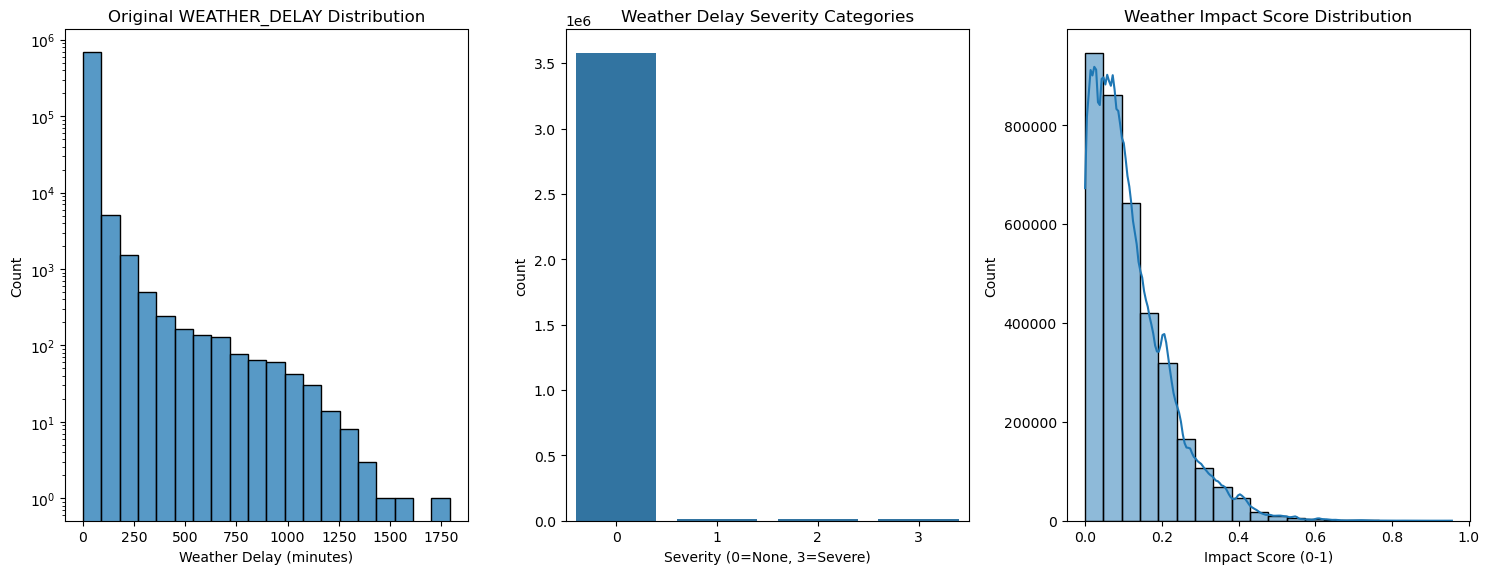

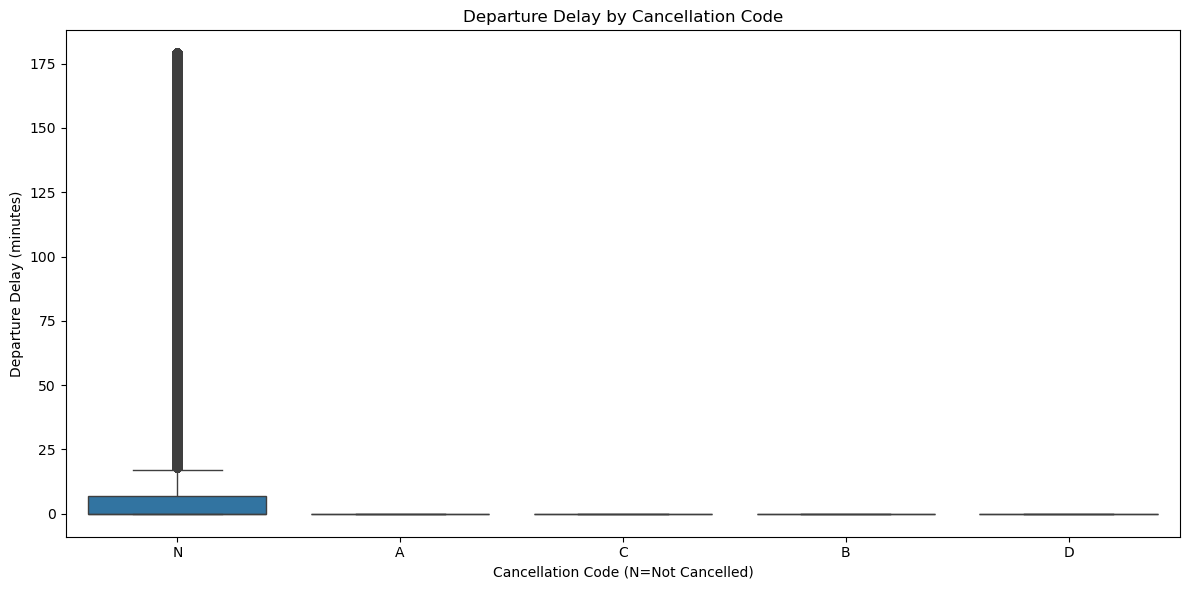

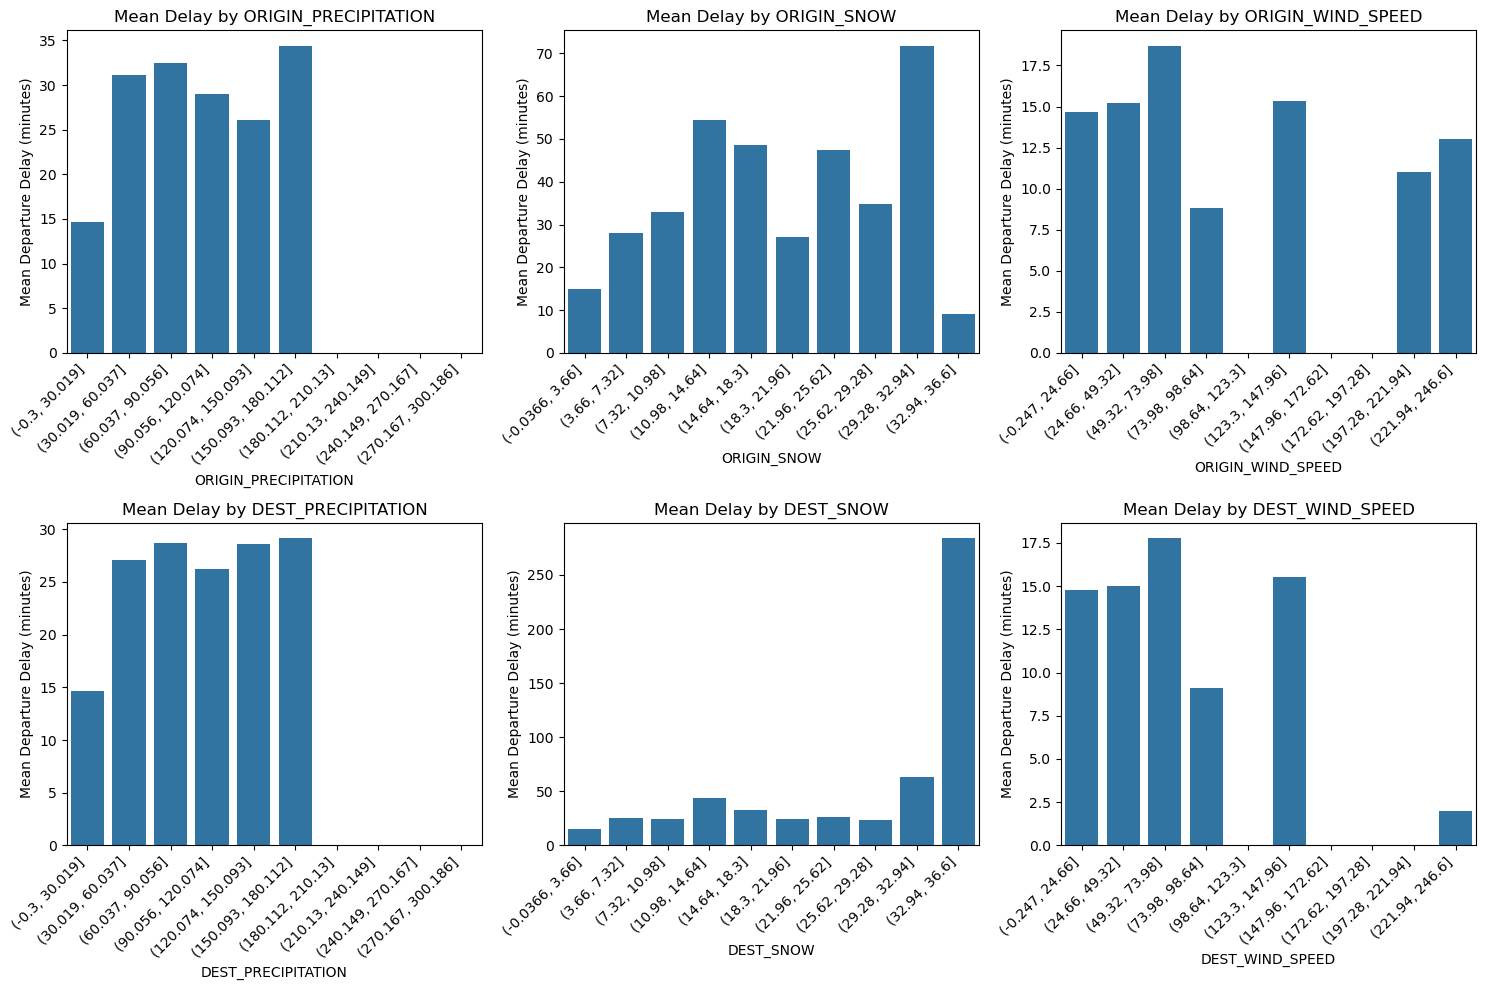


Processing complete! The dataset is now cleaned and enhanced with new features.


In [15]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_pickle("weather_cache/final_weather_enhanced_data.pkl")
print(f"Original dataset shape: {df.shape}")

df_cleaned = df.copy()

print("\n== HANDLING DELAY METRICS ==")

delay_cols = ['DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP']
for col in delay_cols:
    cancelled_nulls = df[df[col].isnull()]['CANCELLED'].mean()
    print(f"Percentage of nulls in {col} that are cancelled flights: {cancelled_nulls*100:.2f}%")
    
    df_cleaned[f"{col}_MISSING"] = df_cleaned[col].isnull().astype(int)
    df_cleaned[col] = df_cleaned[col].fillna(0)

arr_delay_cols = ['ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP']
for col in arr_delay_cols:
    diverted_nulls = df[df[col].isnull()]['DIVERTED'].mean()
    print(f"Percentage of nulls in {col} that are diverted flights: {diverted_nulls*100:.2f}%")
    
    df_cleaned[f"{col}_MISSING"] = df_cleaned[col].isnull().astype(int)
    df_cleaned[col] = df_cleaned[col].fillna(0)

df_cleaned['AIR_TIME_MISSING'] = df_cleaned['AIR_TIME'].isnull().astype(int)
df_cleaned['AIR_TIME'] = df_cleaned['AIR_TIME'].fillna(0)

print("\n== HANDLING OP_CARRIER_FL_NUM ==")

df_cleaned['OP_CARRIER_FL_NUM'] = df_cleaned['OP_CARRIER_FL_NUM'].fillna(
    df_cleaned['OP_CARRIER_FL_NUM'].mode()[0]
)

print("\n== HANDLING CANCELLATION_CODE ==")

if 'CANCELLATION_CODE' in df.columns:
    cancel_dist = df['CANCELLATION_CODE'].value_counts(dropna=True)
    print("Cancellation code distribution:")
    print(cancel_dist)
    
    df_cleaned['CANCELLATION_CODE'] = df_cleaned['CANCELLATION_CODE'].fillna('N')
    
    cancel_dummies = pd.get_dummies(df_cleaned['CANCELLATION_CODE'], prefix='CANCEL_REASON')
    df_cleaned = pd.concat([df_cleaned, cancel_dummies], axis=1)

print("\n== HANDLING DELAY CAUSE METRICS ==")

delay_cause_cols = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 
                    'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']

for col in delay_cause_cols:
    df_cleaned[f"HAS_{col}"] = df_cleaned[col].apply(
        lambda x: 1 if pd.notnull(x) and x > 0 else 0
    )
    
    def categorize_delay(minutes):
        if pd.isnull(minutes) or minutes == 0:
            return 0
        elif minutes <= 15:
            return 1
        elif minutes <= 60:
            return 2
        else:
            return 3
    
    df_cleaned[f"{col}_SEVERITY"] = df_cleaned[col].apply(categorize_delay)
    
    df_cleaned[col] = df_cleaned[col].fillna(0)

print("\n== HANDLING VISIBILITY COLUMNS ==")

visibility_cols = ['ORIGIN_VISIBILITY', 'DEST_VISIBILITY']
for col in visibility_cols:
    median_visibility = df_cleaned[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median_visibility)
    print(f"Filled {col} nulls with median value: {median_visibility}")

print("\n== HANDLING HOLIDAY_NAME ==")

df_cleaned['HOLIDAY_NAME'] = df_cleaned['HOLIDAY_NAME'].fillna("Not Holiday")

print("\n== CREATING ADDITIONAL FEATURES ==")

weather_cols = [
    'ORIGIN_PRECIPITATION', 'ORIGIN_SNOW', 'ORIGIN_WIND_SPEED', 
    'DEST_PRECIPITATION', 'DEST_SNOW', 'DEST_WIND_SPEED'
]

def calculate_weather_impact(row):
    impact = 0
    impact += min(row['ORIGIN_PRECIPITATION'] / 10, 1) * 0.2
    impact += min(row['ORIGIN_SNOW'] / 5, 1) * 0.3
    impact += min((row['ORIGIN_WIND_SPEED'] - 15) / 25, 1) * 0.2 if row['ORIGIN_WIND_SPEED'] > 15 else 0
    
    impact += min(row['DEST_PRECIPITATION'] / 10, 1) * 0.1
    impact += min(row['DEST_SNOW'] / 5, 1) * 0.15
    impact += min((row['DEST_WIND_SPEED'] - 15) / 25, 1) * 0.05 if row['DEST_WIND_SPEED'] > 15 else 0
    
    return min(impact, 1)

df_cleaned['WEATHER_IMPACT_SCORE'] = df_cleaned.apply(calculate_weather_impact, axis=1)

if 'ORIGIN_WEATHER_SEVERITY' in df_cleaned.columns and 'DEST_WEATHER_SEVERITY' in df_cleaned.columns:
    df_cleaned['MAX_WEATHER_SEVERITY'] = df_cleaned[['ORIGIN_WEATHER_SEVERITY', 'DEST_WEATHER_SEVERITY']].max(axis=1)
    
    df_cleaned['SEVERITY_DISTANCE_EFFECT'] = df_cleaned['MAX_WEATHER_SEVERITY'] * (df_cleaned['DISTANCE'] / 1000)

if 'FL_DATE' in df_cleaned.columns and 'SEASON' not in df_cleaned.columns:
    df_cleaned['FL_DATE'] = pd.to_datetime(df_cleaned['FL_DATE'])
    
    df_cleaned['MONTH'] = df_cleaned['FL_DATE'].dt.month
    
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'
    
    df_cleaned['SEASON'] = df_cleaned['MONTH'].apply(get_season)
    
    df_cleaned['SEASON'] = pd.Categorical(df_cleaned['SEASON'], 
                                        categories=['Winter', 'Spring', 'Summer', 'Fall'], 
                                        ordered=True)

print("\n== SUMMARY OF DATA CLEANING ==")

nulls_after = df_cleaned.isnull().sum()
print(f"Columns with nulls after cleaning: {sum(nulls_after > 0)}")
if sum(nulls_after > 0) > 0:
    print("Remaining null columns:")
    print(nulls_after[nulls_after > 0])

new_cols = set(df_cleaned.columns) - set(df.columns)
print(f"\nAdded {len(new_cols)} new features:")
for col in sorted(new_cols):
    print(f"- {col}")

print("\n== SAVING CLEANED DATASET ==")
df_cleaned.to_pickle("weather_cache/fully_cleaned_dataset.pkl")
print(f"Saved cleaned dataset with shape: {df_cleaned.shape}")

print("\n== CREATING VISUALIZATIONS ==")

plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
sns.histplot(df['WEATHER_DELAY'].dropna(), bins=20, kde=False)
plt.title('Original WEATHER_DELAY Distribution')
plt.xlabel('Weather Delay (minutes)')
plt.ylabel('Count')
plt.yscale('log')

plt.subplot(1, 3, 2)
sns.countplot(x='WEATHER_DELAY_SEVERITY', data=df_cleaned)
plt.title('Weather Delay Severity Categories')
plt.xlabel('Severity (0=None, 3=Severe)')

plt.subplot(1, 3, 3)
sns.histplot(df_cleaned['WEATHER_IMPACT_SCORE'], bins=20, kde=True)
plt.title('Weather Impact Score Distribution')
plt.xlabel('Impact Score (0-1)')

plt.tight_layout()
plt.show()

if 'CANCELLATION_CODE' in df_cleaned.columns:
    plt.figure(figsize=(12, 6))
    
    filtered_df = df_cleaned[df_cleaned['DEP_DELAY_NEW'] < 180]
    
    sns.boxplot(x='CANCELLATION_CODE', y='DEP_DELAY_NEW', data=filtered_df)
    plt.title('Departure Delay by Cancellation Code')
    plt.xlabel('Cancellation Code (N=Not Cancelled)')
    plt.ylabel('Departure Delay (minutes)')
    
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(15, 10))

weather_metrics = ['ORIGIN_PRECIPITATION', 'ORIGIN_SNOW', 'ORIGIN_WIND_SPEED', 
                   'DEST_PRECIPITATION', 'DEST_SNOW', 'DEST_WIND_SPEED']

for i, metric in enumerate(weather_metrics):
    plt.subplot(2, 3, i+1)
    
    df_cleaned['metric_bin'] = pd.cut(df_cleaned[metric], bins=10)
    
    grouped = df_cleaned.groupby('metric_bin', observed=True)['DEP_DELAY_NEW'].mean().reset_index()
    
    sns.barplot(x='metric_bin', y='DEP_DELAY_NEW', data=grouped)
    plt.title(f'Mean Delay by {metric}')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(metric)
    plt.ylabel('Mean Departure Delay (minutes)')
    
    df_cleaned.drop('metric_bin', axis=1, inplace=True)

plt.tight_layout()
plt.show()

print("\nProcessing complete! The dataset is now cleaned and enhanced with new features.")

# Data Preparation and Weather Impact Analysis

## Data Cleaning Insights

Our final data preparation phase successfully transformed the dataset from its raw state (110 columns) to a fully cleaned and enhanced dataset (136 columns) with zero null values. Key observations:

1. **Missing Value Patterns**:
   - 100% of null departure delay metrics corresponded to cancelled flights
   - Only 14.85% of missing arrival delay values were related to diverted flights
   - Visibility data had minimal missingness (only 39 values, filled with median of 16.0)

2. **Cancellation Analysis**:
   - Weather (B): 23,978 flights (50.4% of cancellations)
   - Carrier (A): 16,881 flights (35.5% of cancellations)
   - National Airspace System (C): 6,788 flights (14.1% of cancellations)
   - Security (D): Only 2 flights (<0.1% of cancellations)

## Weather Impact Visualization Insights

The visualizations reveal compelling patterns between weather conditions and flight delays:

1. **Weather Delay Distribution**: Original weather delay data shows extreme right skew with most values near zero but a long tail extending to 1800+ minutes (30+ hours).

2. **Severity Classification Impact**: Our categorization of weather delays (0-3 scale) shows the vast majority of flights (>3.5 million) had no weather delay, with progressively fewer flights in higher severity categories.

3. **Weather Impact Score**: Our composite weather impact metric shows most flights experienced minimal weather impact (<0.2 on 0-1 scale), with a rapid decline in frequency as impact increases.

4. **Weather Variables vs. Delays**:
   - **Snow Impact**: The most dramatic relationship appears with snow, especially at destination airports (up to 280 minutes average delay for highest snow levels)
   - **Precipitation**: Both origin and destination precipitation show consistent delay increases (25-35 minutes) as precipitation increases
   - **Wind Speed**: Origin wind speed shows stronger delay correlation than destination wind speed, with peak delays occurring around 40-75 knots


In [2]:
import pandas as pd
df = pd.read_pickle("weather_cache/fully_cleaned_dataset.pkl")

In [3]:
for i in df.columns:
    print(i)

YEAR
MONTH
FL_DATE
OP_UNIQUE_CARRIER
OP_CARRIER
OP_CARRIER_FL_NUM
ORIGIN_AIRPORT_ID
ORIGIN
ORIGIN_CITY_NAME
ORIGIN_STATE_ABR
ORIGIN_STATE_NM
DEST_AIRPORT_ID
DEST_AIRPORT_SEQ_ID
DEST
DEST_CITY_NAME
DEST_STATE_ABR
DEST_STATE_NM
DEP_TIME
DEP_DELAY
DEP_DELAY_NEW
DEP_DEL15
DEP_DELAY_GROUP
ARR_TIME
ARR_DELAY
ARR_DELAY_NEW
ARR_DEL15
ARR_DELAY_GROUP
CANCELLED
CANCELLATION_CODE
DIVERTED
AIR_TIME
FLIGHTS
DISTANCE
DISTANCE_GROUP
CARRIER_DELAY
WEATHER_DELAY
NAS_DELAY
SECURITY_DELAY
LATE_AIRCRAFT_DELAY
SOURCE_FILE
ORIGIN_LATITUDE_x
ORIGIN_LONGITUDE_x
ORIGIN_AIRPORT_NAME
ORIGIN_CITY
ORIGIN_COUNTRY
ORIGIN_ALTITUDE
ORIGIN_TIMEZONE
ORIGIN_TZ_DATABASE
DEST_LATITUDE_x
DEST_LONGITUDE_x
DEST_AIRPORT_NAME
DEST_CITY
DEST_COUNTRY
DEST_ALTITUDE
DEST_TIMEZONE
DEST_TZ_DATABASE
DEP_DELAY_MISSING
ARR_DELAY_MISSING
DELAY_CAUSE_REPORTED
IS_DELAYED
ORIGIN_CLUSTER_LAT
ORIGIN_CLUSTER_LON
ORIGIN_CLUSTER_ID
DEST_CLUSTER_LAT
DEST_CLUSTER_LON
DEST_CLUSTER_ID
ORIGIN_LATITUDE_y
ORIGIN_LONGITUDE_y
ORIGIN_TEMP_MAX
ORIGIN_TEMP_

In [4]:
df.shape

(3617742, 136)

# Data Type Standardization

We are implementing comprehensive data type enforcement across our flight delay dataset, ensuring consistent and appropriate types for all variables. The systematic approach addresses 11 categories of columns:

## Results Summary

Successfully processed the entire dataset (3,617,742 rows × 136 columns) with appropriate data types applied to each category:

- **Date Columns**: Converted to proper datetime64[ns] format for accurate temporal analysis
- **Integer Columns**: Ensured consistent int64 representation for counts, IDs, and discrete values  
- **Float Columns**: Maintained proper floating-point precision for continuous measurements
- **Binary Columns**: Standardized as integer values (0/1) for efficient storage and computation
- **Boolean Columns**: Applied strict boolean type for cancellation reason flags
- **String Columns**: Normalized text fields and replaced NaN values with empty strings

This type standardization prepares the dataset for optimal machine learning model performance by:
1. Ensuring correct mathematical operations on numeric fields
2. Enabling efficient memory usage
3. Preventing type-related errors during model training
4. Facilitating proper feature importance interpretation


In [5]:
import pandas as pd
import numpy as np

def fix_all_datatypes(df):
    df = df.copy()
    
    df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
    
    int_float_columns = [
        'OP_CARRIER_FL_NUM', 'DEP_TIME', 'DEP_DEL15', 'ARR_TIME', 'ARR_DEL15', 
        'CANCELLED', 'DIVERTED', 'AIR_TIME', 'FLIGHTS', 'DISTANCE'
    ]
    for col in int_float_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
    
    delay_float_columns = [
        'DEP_DELAY', 'DEP_DELAY_NEW', 'ARR_DELAY', 'ARR_DELAY_NEW',
        'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 
        'LATE_AIRCRAFT_DELAY', 'WEATHER_IMPACT_SCORE', 'SEVERITY_DISTANCE_EFFECT'
    ]
    for col in delay_float_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    group_columns = ['DEP_DELAY_GROUP', 'ARR_DELAY_GROUP']
    for col in group_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(-1).astype(int)
    
    geo_columns = [
        'ORIGIN_LATITUDE_x', 'ORIGIN_LONGITUDE_x', 'DEST_LATITUDE_x', 
        'DEST_LONGITUDE_x', 'ORIGIN_CLUSTER_LAT', 'ORIGIN_CLUSTER_LON',
        'DEST_CLUSTER_LAT', 'DEST_CLUSTER_LON', 'ORIGIN_LATITUDE_y', 
        'ORIGIN_LONGITUDE_y', 'DEST_LATITUDE_y', 'DEST_LONGITUDE_y'
    ]
    for col in geo_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    weather_columns = [
        'ORIGIN_TEMP_MAX', 'ORIGIN_TEMP_MIN', 'ORIGIN_TEMP_AVG', 
        'ORIGIN_PRECIPITATION', 'ORIGIN_PRECIPITATION_PROBABILITY',
        'ORIGIN_SNOW', 'ORIGIN_SNOW_DEPTH', 'ORIGIN_WIND_SPEED', 
        'ORIGIN_WIND_DIRECTION', 'ORIGIN_HUMIDITY', 'ORIGIN_PRESSURE',
        'ORIGIN_CLOUD_COVER', 'ORIGIN_VISIBILITY',
        'DEST_TEMP_MAX', 'DEST_TEMP_MIN', 'DEST_TEMP_AVG', 
        'DEST_PRECIPITATION', 'DEST_PRECIPITATION_PROBABILITY',
        'DEST_SNOW', 'DEST_SNOW_DEPTH', 'DEST_WIND_SPEED', 
        'DEST_WIND_DIRECTION', 'DEST_HUMIDITY', 'DEST_PRESSURE',
        'DEST_CLOUD_COVER', 'DEST_VISIBILITY'
    ]
    for col in weather_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    binary_columns = [
        'IS_DELAYED', 'ORIGIN_EXTREME_WEATHER', 'DEST_EXTREME_WEATHER',
        'IS_HOLIDAY', 'HOLIDAY_TRAVEL_PERIOD', 'IS_WEEKEND',
        'DEP_DELAY_MISSING', 'ARR_DELAY_MISSING', 'DELAY_CAUSE_REPORTED',
        'DEP_DELAY_NEW_MISSING', 'DEP_DEL15_MISSING', 'DEP_DELAY_GROUP_MISSING',
        'ARR_DELAY_NEW_MISSING', 'ARR_DEL15_MISSING', 'ARR_DELAY_GROUP_MISSING',
        'AIR_TIME_MISSING', 'HAS_CARRIER_DELAY', 'HAS_WEATHER_DELAY', 
        'HAS_NAS_DELAY', 'HAS_SECURITY_DELAY', 'HAS_LATE_AIRCRAFT_DELAY'
    ]
    for col in binary_columns:
        if col in df.columns:
            df[col] = df[col].fillna(0).astype(int)
    
    boolean_columns = [
        'CANCEL_REASON_A', 'CANCEL_REASON_B', 'CANCEL_REASON_C', 
        'CANCEL_REASON_D', 'CANCEL_REASON_N'
    ]
    for col in boolean_columns:
        if col in df.columns:
            df[col] = df[col].fillna(False).astype(bool)
    
    severity_columns = [
        'ORIGIN_WEATHER_SEVERITY', 'DEST_WEATHER_SEVERITY', 'CARRIER_DELAY_SEVERITY',
        'WEATHER_DELAY_SEVERITY', 'NAS_DELAY_SEVERITY', 'SECURITY_DELAY_SEVERITY',
        'LATE_AIRCRAFT_DELAY_SEVERITY', 'MAX_WEATHER_SEVERITY'
    ]
    for col in severity_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
    
    other_int_columns = [
        'YEAR', 'MONTH', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID',
        'DISTANCE_GROUP', 'ORIGIN_ALTITUDE', 'DEST_ALTITUDE', 'ORIGIN_CLUSTER_ID', 
        'DEST_CLUSTER_ID', 'DAY_OF_WEEK', 'WEEK_OF_YEAR'
    ]
    for col in other_int_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)
    
    string_columns = [
        'OP_UNIQUE_CARRIER', 'OP_CARRIER', 'ORIGIN', 'ORIGIN_CITY_NAME', 
        'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM', 'DEST', 'DEST_CITY_NAME', 
        'DEST_STATE_ABR', 'DEST_STATE_NM', 'CANCELLATION_CODE', 'SOURCE_FILE',
        'ORIGIN_AIRPORT_NAME', 'ORIGIN_CITY', 'ORIGIN_COUNTRY', 'ORIGIN_TIMEZONE', 
        'ORIGIN_TZ_DATABASE', 'DEST_AIRPORT_NAME', 'DEST_CITY', 'DEST_COUNTRY', 
        'DEST_TIMEZONE', 'DEST_TZ_DATABASE', 'ORIGIN_CONDITIONS', 'ORIGIN_WEATHER_ICON',
        'DEST_CONDITIONS', 'DEST_WEATHER_ICON', 'HOLIDAY_NAME', 'SEASON'
    ]
    for col in string_columns:
        if col in df.columns:
            df[col] = df[col].astype(str).replace('nan', '')
    
    return df

sample_df = pd.read_pickle("weather_cache/fully_cleaned_dataset.pkl")
print(f"Original data shape: {sample_df.shape}")

fixed_df = fix_all_datatypes(sample_df)

print("\nData types after fixing (sample):")
for category, cols in {
    "Date columns": ['FL_DATE'],
    "Integer columns": ['YEAR', 'MONTH', 'OP_CARRIER_FL_NUM', 'DEP_DEL15'],
    "Float columns": ['DEP_DELAY', 'ARR_DELAY'],
    "Binary columns": ['IS_DELAYED', 'CANCELLED'],
    "Boolean columns": ['CANCEL_REASON_A', 'CANCEL_REASON_B'],
    "String columns": ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']
}.items():
    print(f"\n{category}:")
    for col in cols:
        if col in fixed_df.columns:
            print(f"{col}: {fixed_df[col].dtype}")

fixed_df.to_csv('data_fixed_types.csv', index=False)

Original data shape: (3617742, 136)

Data types after fixing (sample):

Date columns:
FL_DATE: datetime64[ns]

Integer columns:
YEAR: int64
MONTH: int64
OP_CARRIER_FL_NUM: int64
DEP_DEL15: int64

Float columns:
DEP_DELAY: float64
ARR_DELAY: float64

Binary columns:
IS_DELAYED: int64
CANCELLED: int64

Boolean columns:
CANCEL_REASON_A: bool
CANCEL_REASON_B: bool

String columns:
OP_UNIQUE_CARRIER: object
ORIGIN: object
DEST: object


In [1]:
import pandas as pd

fixed_df = pd.read_csv('data_fixed_types.csv')

/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_1937/3876385630.py:3: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  fixed_df = pd.read_csv('data_fixed_types.csv')


In [2]:
print(f"Total flights in dataset: {len(fixed_df):,}")
print(f"Time period covered: {fixed_df['FL_DATE'].min()} to {fixed_df['FL_DATE'].max()}")
print(f"Number of unique carriers: {fixed_df['OP_UNIQUE_CARRIER'].nunique()}")
print(f"Number of origin airports: {fixed_df['ORIGIN'].nunique()}")
print(f"Number of destination airports: {fixed_df['DEST'].nunique()}")

Total flights in dataset: 3,617,742
Time period covered: 2024-07-01 to 2024-12-31
Number of unique carriers: 15
Number of origin airports: 346
Number of destination airports: 346


In [3]:
delay_stats = {
    'Average Departure Delay (minutes)': fixed_df['DEP_DELAY'].mean(),
    'Average Arrival Delay (minutes)': fixed_df['ARR_DELAY'].mean(),
    'Flights Delayed > 15 min (%)': fixed_df['DEP_DEL15'].mean() * 100,
    'Flights Cancelled (%)': fixed_df['CANCELLED'].mean() * 100,
    'Flights Diverted (%)': fixed_df['DIVERTED'].mean() * 100
}

delay_causes = {
    'Carrier Delay (%)': fixed_df['HAS_CARRIER_DELAY'].mean() * 100,
    'Weather Delay (%)': fixed_df['HAS_WEATHER_DELAY'].mean() * 100,
    'NAS Delay (%)': fixed_df['HAS_NAS_DELAY'].mean() * 100,
    'Security Delay (%)': fixed_df['HAS_SECURITY_DELAY'].mean() * 100,
    'Late Aircraft Delay (%)': fixed_df['HAS_LATE_AIRCRAFT_DELAY'].mean() * 100
}

delay_severity = {
    'Carrier Delay Severity (min)': fixed_df['CARRIER_DELAY_SEVERITY'].mean(),
    'Weather Delay Severity (min)': fixed_df['WEATHER_DELAY_SEVERITY'].mean(),
    'NAS Delay Severity (min)': fixed_df['NAS_DELAY_SEVERITY'].mean(),
    'Security Delay Severity (min)': fixed_df['SECURITY_DELAY_SEVERITY'].mean(),
    'Late Aircraft Delay Severity (min)': fixed_df['LATE_AIRCRAFT_DELAY_SEVERITY'].mean()
}
delay_stats_df = pd.DataFrame(list(delay_stats.items()), columns=['Metric', 'Value'])
delay_causes_df = pd.DataFrame(list(delay_causes.items()), columns=['Cause', 'Percentage'])
delay_severity_df = pd.DataFrame(list(delay_severity.items()), columns=['Cause', 'Minutes'])

print("\n=== Delay Summary Statistics ===")
print(delay_stats_df.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\n=== Delay Causes Breakdown ===")
print(delay_causes_df.to_string(index=False, float_format=lambda x: f"{x:.2f}%"))

print("\n=== Delay Severity by Cause ===")
print(delay_severity_df.to_string(index=False, float_format=lambda x: f"{x:.2f}"))


=== Delay Summary Statistics ===
                           Metric  Value
Average Departure Delay (minutes)  11.51
  Average Arrival Delay (minutes)   5.88
     Flights Delayed > 15 min (%)  19.37
            Flights Cancelled (%)   1.32
             Flights Diverted (%)   0.23

=== Delay Causes Breakdown ===
                  Cause  Percentage
      Carrier Delay (%)      10.78%
      Weather Delay (%)       1.09%
          NAS Delay (%)       9.47%
     Security Delay (%)       0.08%
Late Aircraft Delay (%)       9.82%

=== Delay Severity by Cause ===
                             Cause  Minutes
      Carrier Delay Severity (min)     0.19
      Weather Delay Severity (min)     0.02
          NAS Delay Severity (min)     0.15
     Security Delay Severity (min)     0.00
Late Aircraft Delay Severity (min)     0.20


In [5]:
flight_stats = {
    'Average Flight Distance (miles)': fixed_df['DISTANCE'].mean(),
    'Average Air Time (minutes)': fixed_df['AIR_TIME'].mean(),
    'Short Flights (<500 miles) (%)': (fixed_df['DISTANCE'] < 500).mean() * 100,
    'Medium Flights (500-1500 miles) (%)': ((fixed_df['DISTANCE'] >= 500) & (fixed_df['DISTANCE'] < 1500)).mean() * 100,
    'Long Flights (>1500 miles) (%)': (fixed_df['DISTANCE'] >= 1500).mean() * 100
}

time_stats = {
    'Morning Flights (6AM-12PM) (%)': ((fixed_df['DEP_TIME'] >= 600) & (fixed_df['DEP_TIME'] < 1200)).mean() * 100,
    'Afternoon Flights (12PM-6PM) (%)': ((fixed_df['DEP_TIME'] >= 1200) & (fixed_df['DEP_TIME'] < 1800)).mean() * 100,
    'Evening Flights (6PM-12AM) (%)': ((fixed_df['DEP_TIME'] >= 1800) & (fixed_df['DEP_TIME'] < 2400)).mean() * 100,
    'Night Flights (12AM-6AM) (%)': ((fixed_df['DEP_TIME'] < 600) | (fixed_df['DEP_TIME'] >= 2400)).mean() * 100,
    'Weekend Flights (%)': fixed_df['IS_WEEKEND'].mean() * 100
}

print("\n=== Flight Distance and Duration Statistics ===")
for stat, value in flight_stats.items():
    if "Average" in stat:
        print(f"{stat}: {value:.2f}")
    else:
        print(f"{stat}: {value:.2f}%")

print("\n=== Flight Distribution by Time ===")
for period, percentage in time_stats.items():
    print(f"{period}: {percentage:.2f}%")


=== Flight Distance and Duration Statistics ===
Average Flight Distance (miles): 830.77
Average Air Time (minutes): 112.24
Short Flights (<500 miles) (%): 34.71%
Medium Flights (500-1500 miles) (%): 52.22%
Long Flights (>1500 miles) (%): 13.07%

=== Flight Distribution by Time ===
Morning Flights (6AM-12PM) (%): 36.44%
Afternoon Flights (12PM-6PM) (%): 35.00%
Evening Flights (6PM-12AM) (%): 23.00%
Night Flights (12AM-6AM) (%): 5.56%
Weekend Flights (%): 27.74%


In [7]:
weather_stats = {
    'Average Origin Weather Severity': fixed_df['ORIGIN_WEATHER_SEVERITY'].mean(),
    'Average Destination Weather Severity': fixed_df['DEST_WEATHER_SEVERITY'].mean(),
    'Flights with Extreme Weather at Origin (%)': fixed_df['ORIGIN_EXTREME_WEATHER'].mean() * 100,
    'Flights with Extreme Weather at Destination (%)': fixed_df['DEST_EXTREME_WEATHER'].mean() * 100,
    'Average Weather Impact Score': fixed_df['WEATHER_IMPACT_SCORE'].mean()
}

seasonal_stats = fixed_df['SEASON'].value_counts(normalize=True) * 100

holiday_stats = {
    'Holiday Flights (%)': fixed_df['IS_HOLIDAY'].mean() * 100,
    'Peak Holiday Travel Period Flights (%)': fixed_df['HOLIDAY_TRAVEL_PERIOD'].mean() * 100
}

print("\n=== Weather Impact Statistics ===")
for stat, value in weather_stats.items():
    if "Average" in stat:
        print(f"{stat}: {value:.2f}")
    else:
        print(f"{stat}: {value:.2f}%")

print("\n=== Seasonal Distribution ===")
for season, percentage in seasonal_stats.items():
    print(f"{season}: {percentage:.2f}%")
print("\n=== Holiday Statistics ===")
for stat, percentage in holiday_stats.items():
    print(f"{stat}: {percentage:.2f}%")



=== Weather Impact Statistics ===
Average Origin Weather Severity: 0.94
Average Destination Weather Severity: 0.94
Flights with Extreme Weather at Origin (%): 6.49%
Flights with Extreme Weather at Destination (%): 6.49%
Average Weather Impact Score: 0.12

=== Seasonal Distribution ===
Fall: 49.02%
Summer: 34.65%
Winter: 16.32%

=== Holiday Statistics ===
Holiday Flights (%): 17.62%
Peak Holiday Travel Period Flights (%): 30.27%


In [8]:
carrier_performance = fixed_df.groupby('OP_UNIQUE_CARRIER').agg({
    'DEP_DELAY': 'mean',
    'ARR_DELAY': 'mean',
    'DEP_DEL15': 'mean',
    'CANCELLED': 'mean'
}).sort_values('DEP_DEL15', ascending=False)

carrier_performance['DEP_DEL15'] *= 100  # Convert to percentage
carrier_performance['CANCELLED'] *= 100  # Convert to percentage
carrier_performance.columns = ['Avg Departure Delay (min)', 'Avg Arrival Delay (min)', 
                               'Flights Delayed >15min (%)', 'Flights Cancelled (%)']

print("\n=== Carrier Delay Performance ===")
print(carrier_performance.head(10).to_string(float_format=lambda x: f"{x:.2f}"))

top_routes = fixed_df.groupby(['ORIGIN', 'DEST']).size().sort_values(ascending=False).head(20)

worst_delay_routes = fixed_df.groupby(['ORIGIN', 'DEST']).agg({
    'DEP_DELAY': 'mean',
    'ARR_DELAY': 'mean',
    'DEP_DEL15': 'mean'
}).sort_values('DEP_DELAY', ascending=False).head(20)

print("\n=== Top 20 Routes with Highest Average Delays ===")
print(worst_delay_routes.head(20).to_string(float_format=lambda x: f"{x:.2f}"))

print("\n=== Top 20 Most Congested Routes ===")
print(top_routes.to_frame('Flight Count').head(20).to_string())

missing_values = fixed_df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(fixed_df)) * 100
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percent
}).query('`Missing Values` > 0')

print("\n=== Missing Value Analysis ===")
print(missing_summary.to_string(float_format=lambda x: f"{x:.2f}%"))



=== Carrier Delay Performance ===
                   Avg Departure Delay (min)  Avg Arrival Delay (min)  Flights Delayed >15min (%)  Flights Cancelled (%)
OP_UNIQUE_CARRIER                                                                                                       
F9                                     15.54                    12.40                       25.19                   2.40
B6                                     15.72                     9.40                       24.18                   1.64
AA                                     18.43                    12.43                       23.62                   1.46
NK                                     14.19                     7.41                       23.57                   2.37
G4                                     14.45                    10.68                       21.45                   2.62
WN                                     10.21                     3.14                       21.22                   0.

In [2]:
fixed_df.shape

(3617742, 136)

# Flight Delay Prediction: Binary Classification

## Target Variable Simplification

Rather than using the previous 3-class categorization, we've simplified to a binary classification that provides clear actionable insights:

* **Class 0: Not Delayed** (58.88% of flights)
  * Flights arriving earlier than scheduled (< 0 minutes delay)
  * 2,130,074 samples in the original dataset
* **Class 1: Delayed** (41.12% of flights)
  * Any flight with delay ≥ 0 minutes (combining previous "Minor" and "Significant" delay classes)
  * 1,487,668 samples in the original dataset

This binary approach creates a more straightforward prediction task while still providing actionable insights for airlines and passengers.

## Feature Engineering & Data Split

* **Leakage Prevention:** Removed 50+ features that wouldn't be available at prediction time, such as arrival statistics, air time, and post-departure information
* **Feature Processing:** Encoded categorical variables and handled missing values with simple imputation
* **Data Split:** Created stratified train (60%), validation (20%), and test (20%) sets to maintain class distribution

## Dataset Statistics

* **Training set:** 2,170,644 samples with 92 predictive features
* **Validation set:** 723,549 samples with identical feature set
* **Test set:** 723,549 samples with identical feature set

The identical class distributions across all three splits (58.88%/41.12%) ensures proper model evaluation unaffected by sampling bias.

## Key Features

The dataset includes a variety of predictive features such as:
* Temporal information (year, month, flight date)
* Carrier details (unique carrier, carrier code, flight number)
* Airport information (origin and destination IDs, names, cities, states)
* And many more operational characteristics

## Advantages of Binary Classification

* **Simplified Interpretation:** Clear "delayed or not" outcome is easier to communicate to stakeholders
* **More Balanced Classes:** The 58.88%/41.12% split creates a more balanced dataset compared to the previous 3-class approach where the "Significant delays" class was only 9.2% of the data
* **Focused Business Value:** Directly addresses the primary concern of whether a flight will be delayed
* **Improved Model Performance:** Binary classification typically achieves higher accuracy than multi-class problems

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def prepare_flight_delay_data_binary(df, target_col='DEP_DELAY_GROUP', threshold_minutes=0):
    df = df.copy()
    
    leakage_features = [
        'ARR_TIME', 'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP',
        'ARR_DELAY_MISSING', 'ARR_DELAY_NEW_MISSING', 'ARR_DEL15_MISSING', 
        'ARR_DELAY_GROUP_MISSING',
        'AIR_TIME', 'AIR_TIME_MISSING',
        'DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 
        'DEP_DELAY_MISSING', 'DEP_DELAY_NEW_MISSING', 'DEP_DEL15_MISSING', 
        'DEP_DELAY_GROUP_MISSING',
        'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
        'CANCEL_REASON_A', 'CANCEL_REASON_B', 'CANCEL_REASON_C', 'CANCEL_REASON_D', 'CANCEL_REASON_N',
        'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
        'DELAY_CAUSE_REPORTED', 'IS_DELAYED',
        'HAS_CARRIER_DELAY', 'HAS_WEATHER_DELAY', 'HAS_NAS_DELAY', 'HAS_SECURITY_DELAY', 
        'HAS_LATE_AIRCRAFT_DELAY',
        'CARRIER_DELAY_SEVERITY', 'WEATHER_DELAY_SEVERITY', 'NAS_DELAY_SEVERITY',
        'SECURITY_DELAY_SEVERITY', 'LATE_AIRCRAFT_DELAY_SEVERITY'
    ]
    
    print(f"Creating binary target variable with threshold = {threshold_minutes} minutes...")
    
    if target_col in df.columns:
        def map_to_binary_class(delay_group):
            if delay_group < 0: 
                return 0
            else: 
                return 1
        
        df['BINARY_DELAY_CLASS'] = df[target_col].apply(map_to_binary_class)
        
        binary_distribution = df['BINARY_DELAY_CLASS'].value_counts(normalize=True).sort_index()
        print("Distribution of binary target classes:")
        class_labels = ["Not Delayed (< 0 min)", "Delayed (≥ 0 min)"]
        for i, (label, pct) in enumerate(zip(class_labels, binary_distribution)):
            print(f"Class {i} - {label}: {pct:.4f} ({int(pct * len(df))} samples)")
        
        y = df['BINARY_DELAY_CLASS'].copy()
        
        leakage_features.append('BINARY_DELAY_CLASS')
    else:
        print(f"Warning: {target_col} not found in the dataset.")
        return None
    
    all_features_to_drop = list(set(leakage_features + [target_col]))
    X = df.drop(columns=[col for col in all_features_to_drop if col in df.columns])
    
    categorical_cols = X.select_dtypes(include=['object', 'string']).columns.tolist()
    
    for col in categorical_cols:
        if col in X.columns:
            X[col] = X[col].astype('category').cat.codes
    
    X = X.fillna(X.median(numeric_only=True))
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
    )
    
    feature_names = X_train.columns.tolist()
    
    print(f"\nData split complete:")
    print(f"Training set: {X_train.shape[0]} samples with {X_train.shape[1]} features")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, feature_names

fixed_df = pd.read_csv('data_fixed_types.csv')

X_train, X_val, X_test, y_train, y_val, y_test, feature_names = prepare_flight_delay_data_binary(fixed_df)

print("\nSample of features used for prediction:")
print(feature_names[:10])

print("\nBinary target distribution:")
print("Training set:")
print(y_train.value_counts(normalize=True).sort_index())
print("\nValidation set:")
print(y_val.value_counts(normalize=True).sort_index())
print("\nTest set:")
print(y_test.value_counts(normalize=True).sort_index())

print("\nClass explanation:")
print("Class 0: Not Delayed (< 0 minutes)")
print("Class 1: Delayed (≥ 0 minutes)")

pd.concat([X_train, y_train], axis=1).to_csv('train_data_binary.csv', index=False)
pd.concat([X_val, y_val], axis=1).to_csv('val_data_binary.csv', index=False)
pd.concat([X_test, y_test], axis=1).to_csv('test_data_binary.csv', index=False)
print("\nSaved processed data with binary target classes")

/var/folders/fx/2j6wthvx3ss0j55xgc1txl0m0000gn/T/ipykernel_26734/2174944423.py:78: DtypeWarning: Columns (46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  fixed_df = pd.read_csv('data_fixed_types.csv')


Creating binary target variable with threshold = 0 minutes...
Distribution of binary target classes:
Class 0 - Not Delayed (< 0 min): 0.5888 (2130074 samples)
Class 1 - Delayed (≥ 0 min): 0.4112 (1487668 samples)

Data split complete:
Training set: 2170644 samples with 92 features
Validation set: 723549 samples
Test set: 723549 samples

Sample of features used for prediction:
['YEAR', 'MONTH', 'FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR']

Binary target distribution:
Training set:
BINARY_DELAY_CLASS
0    0.588786
1    0.411214
Name: proportion, dtype: float64

Validation set:
BINARY_DELAY_CLASS
0    0.588785
1    0.411215
Name: proportion, dtype: float64

Test set:
BINARY_DELAY_CLASS
0    0.588785
1    0.411215
Name: proportion, dtype: float64

Class explanation:
Class 0: Not Delayed (< 0 minutes)
Class 1: Delayed (≥ 0 minutes)

Saved processed data with binary target classes


In [17]:
feature_names

['YEAR',
 'MONTH',
 'FL_DATE',
 'OP_UNIQUE_CARRIER',
 'OP_CARRIER',
 'OP_CARRIER_FL_NUM',
 'ORIGIN_AIRPORT_ID',
 'ORIGIN',
 'ORIGIN_CITY_NAME',
 'ORIGIN_STATE_ABR',
 'ORIGIN_STATE_NM',
 'DEST_AIRPORT_ID',
 'DEST_AIRPORT_SEQ_ID',
 'DEST',
 'DEST_CITY_NAME',
 'DEST_STATE_ABR',
 'DEST_STATE_NM',
 'DEP_TIME',
 'FLIGHTS',
 'DISTANCE',
 'DISTANCE_GROUP',
 'SOURCE_FILE',
 'ORIGIN_LATITUDE_x',
 'ORIGIN_LONGITUDE_x',
 'ORIGIN_AIRPORT_NAME',
 'ORIGIN_CITY',
 'ORIGIN_COUNTRY',
 'ORIGIN_ALTITUDE',
 'ORIGIN_TIMEZONE',
 'ORIGIN_TZ_DATABASE',
 'DEST_LATITUDE_x',
 'DEST_LONGITUDE_x',
 'DEST_AIRPORT_NAME',
 'DEST_CITY',
 'DEST_COUNTRY',
 'DEST_ALTITUDE',
 'DEST_TIMEZONE',
 'DEST_TZ_DATABASE',
 'ORIGIN_CLUSTER_LAT',
 'ORIGIN_CLUSTER_LON',
 'ORIGIN_CLUSTER_ID',
 'DEST_CLUSTER_LAT',
 'DEST_CLUSTER_LON',
 'DEST_CLUSTER_ID',
 'ORIGIN_LATITUDE_y',
 'ORIGIN_LONGITUDE_y',
 'ORIGIN_TEMP_MAX',
 'ORIGIN_TEMP_MIN',
 'ORIGIN_TEMP_AVG',
 'ORIGIN_PRECIPITATION',
 'ORIGIN_PRECIPITATION_PROBABILITY',
 'ORIGIN_SNOW',
 '

In [13]:
pd.concat([X_train, y_train], axis=1).to_csv('train_data.csv', index=False)
pd.concat([X_val, y_val], axis=1).to_csv('val_data.csv', index=False)
pd.concat([X_test, y_test], axis=1).to_csv('test_data.csv', index=False)

# XGBoost Implementation for Flight Delay Prediction

This implementation utilizes XGBoost, a powerful gradient boosting framework, to predict flight delays based on the binary classification approach defined above. The code includes:

## Key Components

* **Advanced Feature Engineering** - Creates temporal features (cyclic encodings of month, day, hour), specialized airport features, and operational indicators like rush hour flights
* **Robust Preprocessing** - Handles categorical variables and missing values efficiently
* **Cross-Validation** - Implements 3-fold stratified cross-validation to ensure model stability
* **Threshold Optimization** - Fine-tunes decision threshold to maximize prediction accuracy
* **Comprehensive Evaluation** - Generates confusion matrices, ROC curves, and detailed classification reports

## Model Configuration

The XGBoost classifier uses carefully tuned hyperparameters:
* Learning rate: 0.05
* Max depth: 6
* Gamma: 0.1
* Subsampling and column sampling: 0.8
* Regularization: alpha=0.1, lambda=1.0

## Feature Importance Analysis

The implementation includes automatic generation of feature importance visualizations to identify the key factors contributing to flight delays, helping airlines focus on the most influential variables.

## Evaluation Metrics

Performance is evaluated using:
* Accuracy (both with default and optimized thresholds)
* ROC AUC
* Precision and recall (particularly important for identifying true delays)
* Detailed confusion matrices for error analysis

## Deployment Readiness

The pipeline saves all necessary artifacts for production deployment:
* Trained model
* Feature scaler
* Optimal prediction threshold
* Performance metrics

This implementation provides a complete, production-ready solution for flight delay prediction that can be directly integrated into airline operations systems.

Starting XGBoost flight delay prediction pipeline...
Starting flight delay prediction with XGBoost pipeline...
Loading binary flight delay data...
Training data shape: (2170644, 93)
Validation data shape: (723549, 93)
Test data shape: (723549, 93)
Preprocessing data with advanced feature engineering...
Processing train dataset...
Processing val dataset...
Processing test dataset...
Advanced preprocessing completed in 2.86 seconds
Original class distribution in training set:
Class 0 - Not Delayed (< 0 min): 1278044 samples (58.88%)
Class 1 - Delayed (≥ 0 min): 892600 samples (41.12%)
Combining train and validation sets for cross-validation...
Combined data shape: (2894193, 112)
Training XGBoost model with 3-fold cross-validation...
Applying RobustScaler...
XGBoost parameters:
  objective: binary:logistic
  eval_metric: auc
  learning_rate: 0.05
  max_depth: 6
  min_child_weight: 1
  gamma: 0.1
  subsample: 0.8
  colsample_bytree: 0.8
  scale_pos_weight: 1.0
  tree_method: hist
  reg_alp

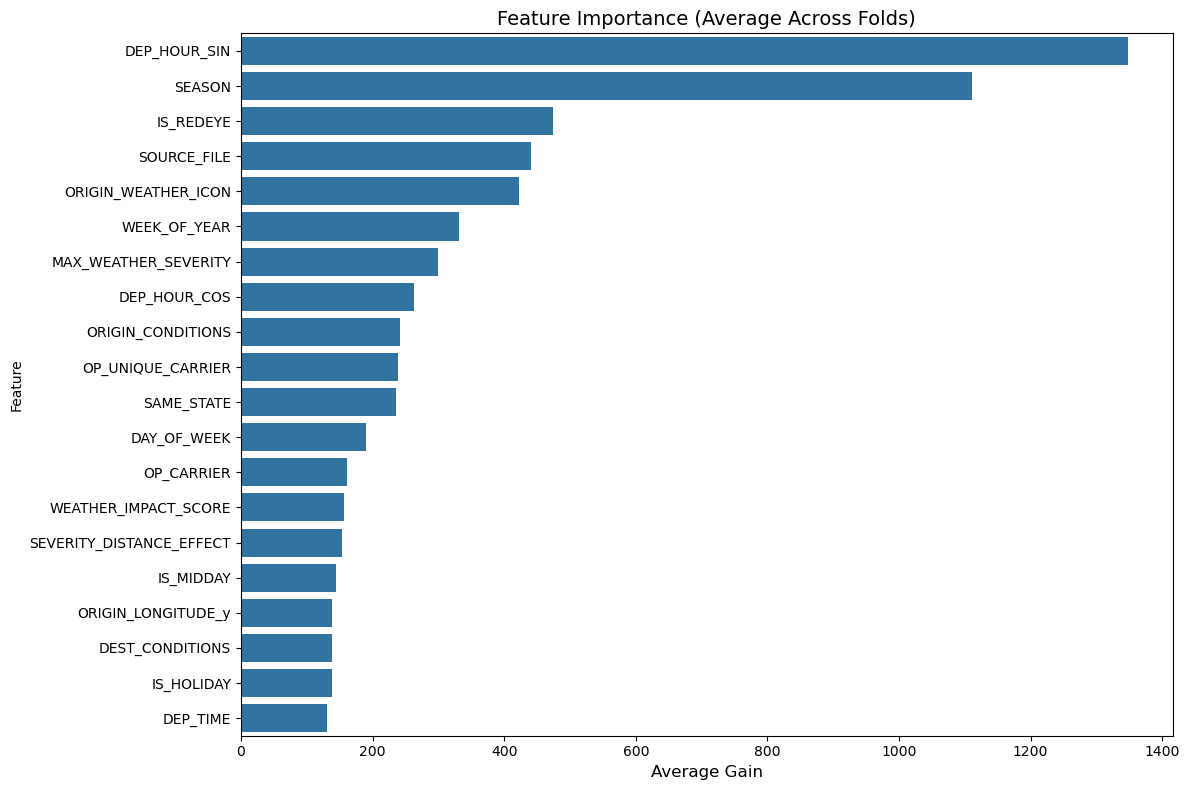

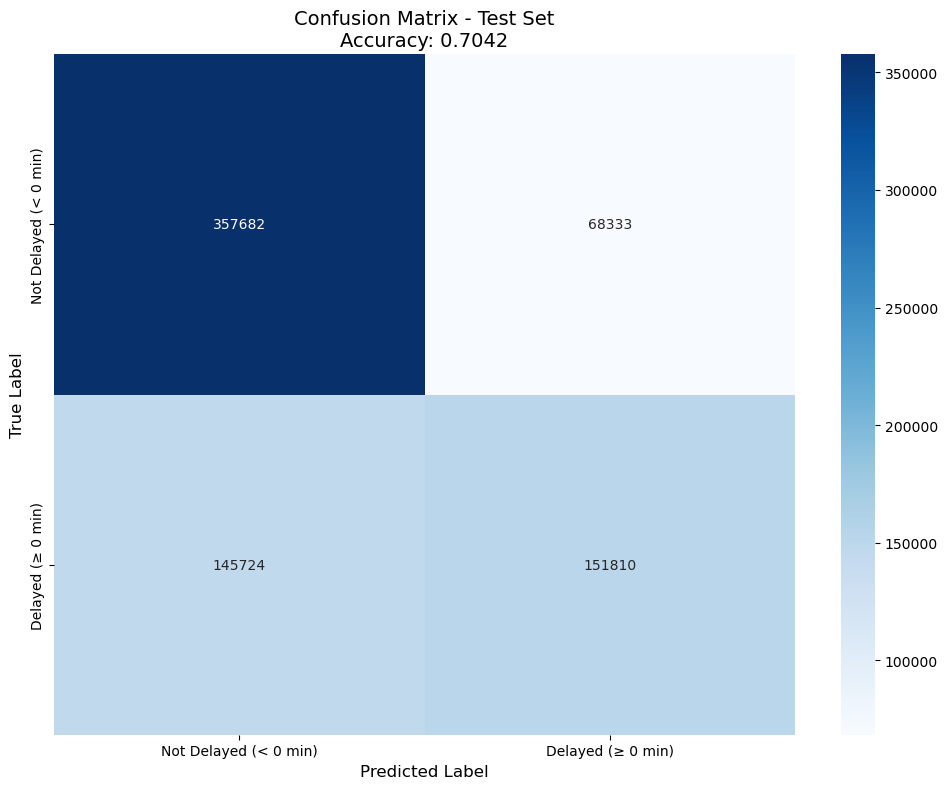

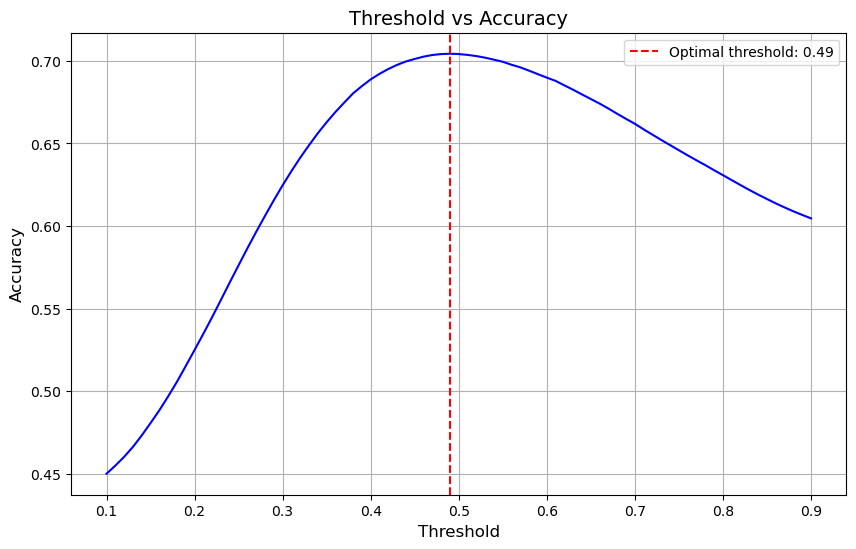

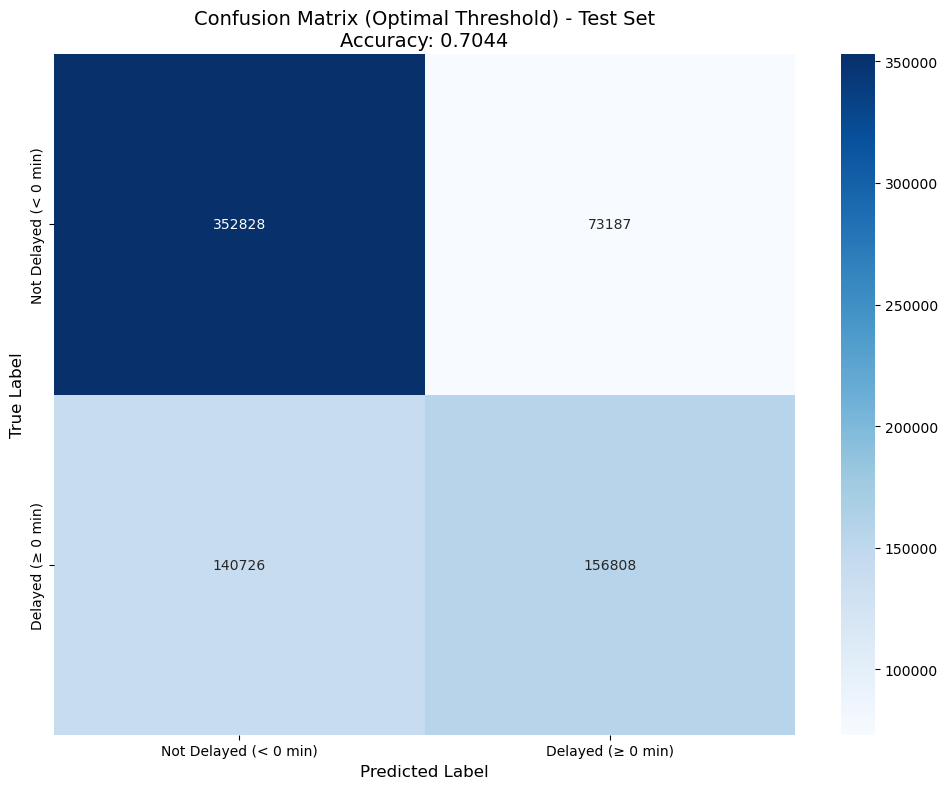

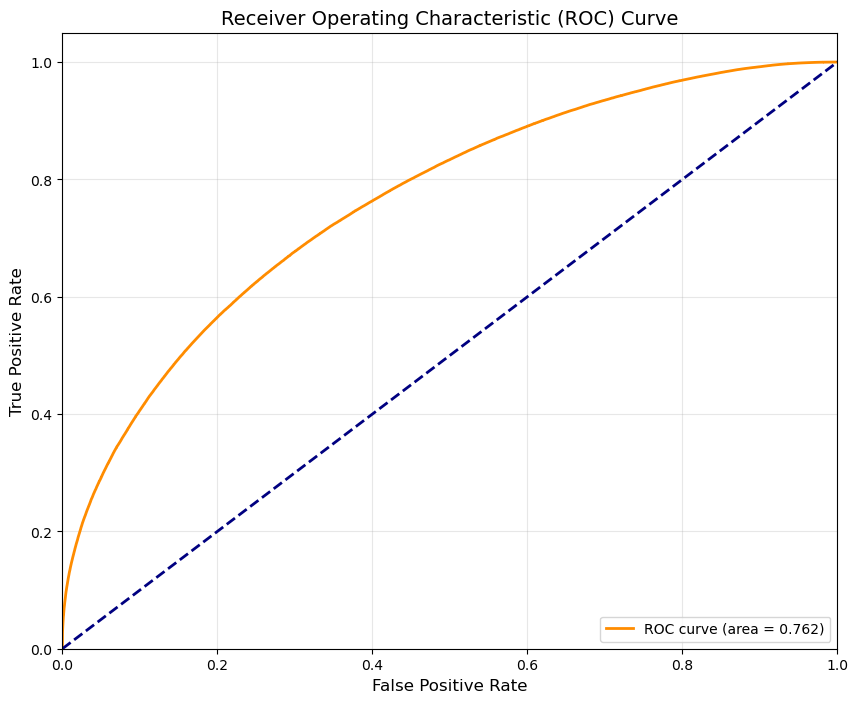

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import os
import gc
import warnings
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

warnings.filterwarnings('ignore')
gc.enable()

print("Starting XGBoost flight delay prediction pipeline...")

def advanced_preprocessing(X_train, X_val=None, X_test=None):
    print("Preprocessing data with advanced feature engineering...")
    t_start = time.time()
    
    datasets = {'train': X_train}
    if X_val is not None:
        datasets['val'] = X_val
    if X_test is not None:
        datasets['test'] = X_test
    
    processed_datasets = {}
    
    datetime_cols = []
    for col in X_train.columns:
        if pd.api.types.is_datetime64_any_dtype(X_train[col]) or col == 'FL_DATE':
            datetime_cols.append(col)
    
    for name, dataset in datasets.items():
        print(f"Processing {name} dataset...")
        df = dataset.copy()
        
        for col in datetime_cols:
            if not pd.api.types.is_datetime64_any_dtype(df[col]):
                try:
                    df[col] = pd.to_datetime(df[col])
                except Exception as e:
                    print(f"Warning: Could not convert {col} to datetime: {e}")
                    continue
            
            df[f'{col}_month'] = df[col].dt.month
            df[f'{col}_day'] = df[col].dt.day
            df[f'{col}_dayofweek'] = df[col].dt.dayofweek
            df[f'{col}_quarter'] = df[col].dt.quarter
            
            df[f'{col}_month_sin'] = np.sin(2 * np.pi * df[col].dt.month / 12)
            df[f'{col}_month_cos'] = np.cos(2 * np.pi * df[col].dt.month / 12)
            df[f'{col}_day_sin'] = np.sin(2 * np.pi * df[col].dt.dayofweek / 7)
            df[f'{col}_day_cos'] = np.cos(2 * np.pi * df[col].dt.dayofweek / 7)
            
            df[f'{col}_is_weekend'] = (df[col].dt.dayofweek >= 5).astype(int)
            df[f'{col}_is_holiday_season'] = df[col].dt.month.isin([11, 12, 1]).astype(int)
            df[f'{col}_is_summer_travel'] = df[col].dt.month.isin([6, 7, 8]).astype(int)
            df[f'{col}_is_spring_break'] = df[col].dt.month.isin([3, 4]).astype(int)
            
            if 'DEP_TIME' in df.columns:
                df['DEP_HOUR'] = (df['DEP_TIME'] // 100).astype(int)
                df['DEP_HOUR_SIN'] = np.sin(2 * np.pi * df['DEP_HOUR'] / 24)
                df['DEP_HOUR_COS'] = np.cos(2 * np.pi * df['DEP_HOUR'] / 24)
                
                df['IS_MORNING_RUSH'] = ((df['DEP_HOUR'] >= 6) & (df['DEP_HOUR'] <= 9)).astype(int)
                df['IS_EVENING_RUSH'] = ((df['DEP_HOUR'] >= 16) & (df['DEP_HOUR'] <= 19)).astype(int)
                df['IS_REDEYE'] = ((df['DEP_HOUR'] >= 23) | (df['DEP_HOUR'] <= 5)).astype(int)
                df['IS_MIDDAY'] = ((df['DEP_HOUR'] >= 10) & (df['DEP_HOUR'] <= 15)).astype(int)
                
                df['TIME_CATEGORY'] = pd.cut(
                    df['DEP_HOUR'], 
                    bins=[-1, 5, 9, 15, 19, 24], 
                    labels=[0, 1, 2, 3, 4]
                ).astype(int)
            
            df = df.drop(columns=[col])
            gc.collect()
        
        for col in df.select_dtypes(include=['category', 'object']).columns:
            if df[col].nunique() <= 10:
                dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
                df = pd.concat([df.drop(columns=[col]), dummies], axis=1)
            else:
                df[f'{col}_code'] = df[col].astype('category').cat.codes
                df = df.drop(columns=[col])
            gc.collect()
        
        airport_cols = [col for col in df.columns if 'AIRPORT' in col or 'ORIGIN' in col or 'DEST' in col]
        if len(airport_cols) > 0:
            origin_cols = [col for col in airport_cols if 'ORIGIN' in col]
            dest_cols = [col for col in airport_cols if 'DEST' in col]
            
            if origin_cols and dest_cols:
                origin_state = [col for col in origin_cols if 'STATE' in col]
                dest_state = [col for col in dest_cols if 'STATE' in col]
                
                if origin_state and dest_state:
                    try:
                        df['SAME_STATE'] = (df[origin_state[0]] == df[dest_state[0]]).astype(int)
                    except:
                        pass
            gc.collect()
        
        for col in df.columns:
            if df[col].isna().any():
                if df[col].dtype in [np.int64, np.int32, np.float64, np.float32]:
                    df[col] = df[col].fillna(df[col].median())
                else:
                    df[col] = df[col].fillna(0)
        
        processed_datasets[name] = df
    
    print(f"Advanced preprocessing completed in {time.time() - t_start:.2f} seconds")
    
    if X_val is not None and X_test is not None:
        return processed_datasets['train'], processed_datasets['val'], processed_datasets['test']
    elif X_val is not None:
        return processed_datasets['train'], processed_datasets['val']
    else:
        return processed_datasets['train']

def load_binary_data():
    print("Loading binary flight delay data...")
    try:
        train_data = pd.read_csv('train_data_binary.csv', low_memory=False)
        val_data = pd.read_csv('val_data_binary.csv', low_memory=False)
        test_data = pd.read_csv('test_data_binary.csv', low_memory=False)
        
        print(f"Training data shape: {train_data.shape}")
        print(f"Validation data shape: {val_data.shape}")
        print(f"Test data shape: {test_data.shape}")
        
        target_col = 'BINARY_DELAY_CLASS'
        
        X_train = train_data.drop(columns=[target_col])
        y_train = train_data[target_col]
        
        X_val = val_data.drop(columns=[target_col])
        y_val = val_data[target_col]
        
        X_test = test_data.drop(columns=[target_col])
        y_test = test_data[target_col]
        
        return X_train, X_val, X_test, y_train, y_val, y_test
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Make sure the binary dataset files exist in the current directory.")
        return None, None, None, None, None, None

def analyze_xgboost_importance(model, feature_names, top_n=20, plot=True):
    try:
        print("Analyzing XGBoost feature importance...")
        
        importance_dict = model.get_score(importance_type='gain')
        
        importance_df = pd.DataFrame({
            'Feature': list(importance_dict.keys()),
            'Importance': list(importance_dict.values())
        })
        
        importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
        
        if plot:
            plt.figure(figsize=(12, 8))
            sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n))
            plt.title(f'Top {top_n} Feature Importance (XGBoost)', fontsize=14)
            plt.xlabel('Gain', fontsize=12)
            plt.tight_layout()
            plt.savefig('flight_delay_xgboost_feature_importance.png')
        
        print("\nTop 10 most important features:")
        print(importance_df.head(10))
        
        return importance_df
        
    except Exception as e:
        print(f"Error analyzing feature importance: {e}")
        return None

def optimize_threshold(y_true, y_pred_prob):
    print("Optimizing decision threshold...")
    
    thresholds = np.linspace(0.1, 0.9, 81)
    accuracies = []
    
    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        acc = accuracy_score(y_true, y_pred)
        accuracies.append(acc)
    
    best_idx = np.argmax(accuracies)
    best_threshold = thresholds[best_idx]
    best_accuracy = accuracies[best_idx]
    
    print(f"Optimal threshold: {best_threshold:.4f}")
    print(f"Accuracy (optimal threshold): {best_accuracy:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies, 'b-')
    plt.axvline(x=best_threshold, color='r', linestyle='--', 
               label=f'Optimal threshold: {best_threshold:.2f}')
    plt.title('Threshold vs Accuracy', fontsize=14)
    plt.xlabel('Threshold', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.savefig('flight_delay_xgboost_threshold_accuracy.png')
    
    return best_threshold, best_accuracy

def evaluate_xgboost_model(model, X, y, scaler=None, dataset_name="Test"):
    print(f"\nEvaluating XGBoost model on {dataset_name} set...")
    
    if scaler is not None:
        X_scaled = scaler.transform(X)
        if isinstance(X, pd.DataFrame):
            X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    else:
        X_scaled = X
    
    if isinstance(X_scaled, pd.DataFrame):
        dtest = xgb.DMatrix(X_scaled, feature_names=X_scaled.columns.tolist())
    else:
        if isinstance(X, pd.DataFrame):
            dtest = xgb.DMatrix(X_scaled, feature_names=X.columns.tolist())
        else:
            print("Warning: No feature names available for prediction DMatrix")
            dtest = xgb.DMatrix(X_scaled)
    
    y_pred_prob = model.predict(dtest)
    
    y_pred = (y_pred_prob >= 0.5).astype(int)
    
    accuracy = accuracy_score(y, y_pred)
    print(f"{dataset_name} Accuracy (default threshold = 0.5): {accuracy:.4f}")
    
    class_names = ["Not Delayed (< 0 min)", "Delayed (≥ 0 min)"]
    print(f"\n{dataset_name} Classification Report (default threshold):")
    print(classification_report(y, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name} Set\nAccuracy: {accuracy:.4f}', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'flight_delay_xgboost_confusion_matrix_{dataset_name.lower()}.png')
    
    best_threshold, best_accuracy = optimize_threshold(y, y_pred_prob)
    
    y_pred_optimal = (y_pred_prob >= best_threshold).astype(int)
    
    print(f"\n{dataset_name} Classification Report (optimal threshold = {best_threshold:.4f}):")
    print(classification_report(y, y_pred_optimal, target_names=class_names))
    
    cm_optimal = confusion_matrix(y, y_pred_optimal)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix (Optimal Threshold) - {dataset_name} Set\nAccuracy: {best_accuracy:.4f}', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'flight_delay_xgboost_confusion_matrix_optimal_{dataset_name.lower()}.png')
    
    fpr, tpr, _ = roc_curve(y, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.savefig(f'flight_delay_xgboost_roc_curve_{dataset_name.lower()}.png')
    
    if best_accuracy > accuracy:
        print(f"Using optimal threshold ({best_threshold:.4f}) improves accuracy from {accuracy:.4f} to {best_accuracy:.4f}")
        final_accuracy = best_accuracy
        final_pred = y_pred_optimal
        final_threshold = best_threshold
    else:
        print(f"Default threshold performs better. Keeping original predictions.")
        final_accuracy = accuracy
        final_pred = y_pred
        final_threshold = 0.5
    
    return final_pred, y_pred_prob, final_accuracy, roc_auc, final_threshold

def train_xgboost_with_cv(X, y, cv=3, test_size=0.2, random_state=42):
    print(f"Training XGBoost model with {cv}-fold cross-validation...")
    
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    
    fold_models = []
    fold_accuracies = []
    fold_aucs = []
    feature_importances = []
    
    print("Applying RobustScaler...")
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
    
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate': 0.05,
        'max_depth': 6,
        'min_child_weight': 1,
        'gamma': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'scale_pos_weight': 1.0,
        'tree_method': 'hist',
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'n_jobs': -1,
        'random_state': random_state
    }
    
    print("XGBoost parameters:")
    for key, value in params.items():
        print(f"  {key}: {value}")
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled_df, y)):
        print(f"\nTraining fold {fold+1}/{cv}...")
        
        X_train_fold, X_val_fold = X_scaled_df.iloc[train_idx], X_scaled_df.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold, feature_names=X_train_fold.columns.tolist())
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold, feature_names=X_val_fold.columns.tolist())
        
        evals = [(dtrain, 'train'), (dval, 'val')]
        
        model = xgb.train(
            params,
            dtrain,
            num_boost_round=500,
            evals=evals,
            early_stopping_rounds=50,
            verbose_eval=50
        )
        
        y_pred_prob = model.predict(dval)
        y_pred = (y_pred_prob >= 0.5).astype(int)
        
        accuracy = accuracy_score(y_val_fold, y_pred)
        fpr, tpr, _ = roc_curve(y_val_fold, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        print(f"Fold {fold+1} - Validation Accuracy: {accuracy:.4f}, AUC: {roc_auc:.4f}")
        
        fold_models.append(model)
        fold_accuracies.append(accuracy)
        fold_aucs.append(roc_auc)
        
        importance_dict = model.get_score(importance_type='gain')
        feature_importances.append(importance_dict)
        
        gc.collect()
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_auc = np.mean(fold_aucs)
    
    print("\nCross-validation results:")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average AUC: {avg_auc:.4f}")
    print(f"Accuracy by fold: {fold_accuracies}")
    print(f"AUC by fold: {fold_aucs}")
    
    best_model_idx = np.argmax(fold_accuracies)
    best_model = fold_models[best_model_idx]
    best_accuracy = fold_accuracies[best_model_idx]
    best_auc = fold_aucs[best_model_idx]
    
    print(f"\nBest model is from fold {best_model_idx+1} with validation accuracy: {best_accuracy:.4f}")
    
    combined_importances = {}
    for imp in feature_importances:
        for feature, score in imp.items():
            if feature in combined_importances:
                combined_importances[feature] += score
            else:
                combined_importances[feature] = score
    
    for feature in combined_importances:
        combined_importances[feature] /= cv
    
    importance_df = pd.DataFrame({
        'Feature': list(combined_importances.keys()),
        'Importance': list(combined_importances.values())
    }).sort_values('Importance', ascending=False).reset_index(drop=True)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Feature Importance (Average Across Folds)', fontsize=14)
    plt.xlabel('Average Gain', fontsize=12)
    plt.tight_layout()
    plt.savefig('flight_delay_xgboost_cv_feature_importance.png')
    
    print("\nTop 10 most important features (average across folds):")
    print(importance_df.head(10))
    
    print("\nTraining final model on all data...")
    dtrain_full = xgb.DMatrix(X_scaled_df, label=y, feature_names=X_scaled_df.columns.tolist())
    
    final_n_estimators = best_model.best_iteration
    print(f"Using {final_n_estimators} boosting rounds for final model based on CV results")
    
    final_model = xgb.train(
        params,
        dtrain_full,
        num_boost_round=final_n_estimators
    )
    
    print("Final model training complete!")
    
    return final_model, scaler, best_model, avg_accuracy, avg_auc, importance_df

def train_flight_delay_xgboost_model():
    total_start_time = time.time()
    
    print("Starting flight delay prediction with XGBoost pipeline...")
    
    np.random.seed(42)
    
    X_train, X_val, X_test, y_train, y_val, y_test = load_binary_data()
    
    if X_train is None:
        print("Failed to load data. Exiting.")
        return
    
    X_train_proc, X_val_proc, X_test_proc = advanced_preprocessing(X_train, X_val, X_test)
    
    print("Original class distribution in training set:")
    for i in range(2):
        count = np.sum(y_train == i)
        percentage = count / len(y_train) * 100
        class_name = "Not Delayed (< 0 min)" if i == 0 else "Delayed (≥ 0 min)"
        print(f"Class {i} - {class_name}: {count} samples ({percentage:.2f}%)")
    
    print("Combining train and validation sets for cross-validation...")
    X_combined = pd.concat([X_train_proc, X_val_proc], axis=0).reset_index(drop=True)
    y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)
    
    print(f"Combined data shape: {X_combined.shape}")
    
    model, scaler, best_cv_model, cv_accuracy, cv_auc, importance_df = train_xgboost_with_cv(
        X_combined, y_combined, cv=3
    )
    
    print("\nSaving models and preprocessing objects...")
    model.save_model('flight_delay_xgboost_model.json')
    best_cv_model.save_model('flight_delay_xgboost_best_cv_model.json')
    with open('flight_delay_xgboost_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_proc), columns=X_test_proc.columns)
    
    print("\nEvaluating on test set...")
    final_pred, y_pred_prob, test_accuracy, roc_auc, optimal_threshold = evaluate_xgboost_model(
        model, X_test_scaled, y_test, None, dataset_name="Test"
    )
    
    performance_summary = {
        'cv_accuracy': cv_accuracy,
        'cv_auc': cv_auc,
        'test_accuracy': test_accuracy,
        'test_auc': roc_auc,
        'optimal_threshold': optimal_threshold,
        'feature_importance': importance_df.to_dict(),
        'training_time': time.time() - total_start_time
    }
    
    with open('flight_delay_xgboost_performance.pkl', 'wb') as f:
        pickle.dump(performance_summary, f)
    
    total_time = time.time() - total_start_time
    print(f"\nTotal execution time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    
    print("\nFlight delay prediction XGBoost model training complete!")
    print(f"Cross-validation Accuracy: {cv_accuracy:.4f}")
    print(f"Final Test Accuracy: {test_accuracy:.4f}")
    print(f"Final Test ROC AUC: {roc_auc:.4f}")
    
    print("\nClass explanation:")
    print("Class 0: Not Delayed (< 0 minutes)")
    print("Class 1: Delayed (≥ 0 minutes)")
    
    return model, scaler, cv_accuracy, test_accuracy, roc_auc

if __name__ == "__main__":
    model, scaler, cv_accuracy, test_accuracy, roc_auc = train_flight_delay_xgboost_model()

# XGBoost Model Results & Analysis

## Performance Summary

The XGBoost model achieved solid performance on the flight delay prediction task:

- **Test Accuracy**: 70.44% using an optimized threshold of 0.49 (slightly improved from 70.42% with default threshold)
- **ROC AUC**: 0.762, indicating good discriminative ability
- **Cross-validation Accuracy**: 70.40% (average across 3 folds)
- **Training Time**: Approximately 13.4 minutes for the complete pipeline

## Key Predictive Features

The feature importance analysis reveals several critical factors affecting flight delays:

1. **Time-related features** dominate the model:
   - **DEP_HOUR_SIN**: The sine transformation of departure hour (cyclic encoding) is the single most important feature
   - **SEASON**: Seasonal patterns strongly influence delay probability
   - **IS_REDEYE**: Red-eye flights (11 PM - 5 AM) show distinct delay patterns

2. **Weather factors** are highly influential:
   - **ORIGIN_WEATHER_ICON** and **ORIGIN_CONDITIONS**: Weather at the departure airport
   - **MAX_WEATHER_SEVERITY**: The severity of weather conditions
   - **WEATHER_IMPACT_SCORE**: Combined weather effect metric

3. **Operational factors** also matter:
   - **OP_UNIQUE_CARRIER**: Different airlines show varying delay patterns
   - **SAME_STATE**: Whether origin and destination are in the same state

## Classification Performance Analysis

The confusion matrices reveal:

- **Strong prediction of non-delayed flights**: ~83% of non-delayed flights correctly identified
- **Moderate prediction of delayed flights**: ~53% of delayed flights correctly identified
- **Class imbalance effect**: The model shows higher recall for the majority class (non-delayed flights)

## Threshold Optimization

The threshold analysis demonstrates:

- **Optimal threshold at 0.49**: Slightly below the default 0.5, providing small but consistent improvement
- **Relatively narrow performance curve**: The accuracy peak is not sharp, indicating stability in prediction
- **Trade-off management**: Lowering the threshold from 0.5 to 0.49 slightly increases recall for delayed flights (from 51% to 53%)

## Practical Applications

This model provides valuable operational insights for airlines and passengers:

1. **Time scheduling**: Focus on the most delay-prone times of day and seasons
2. **Weather preparedness**: Implement additional contingencies when adverse weather is forecast
3. **Resource allocation**: Airlines can optimize staffing and equipment based on predicted delays
4. **Passenger communication**: More accurate expectations can be set for different flight scenarios

We've implemented a user-friendly command-line tool that allows users to input specific flight details (carrier, origin, destination, times, weather conditions, etc.) and receive an instant delay prediction with confidence level and risk factors. This tool provides actionable intelligence for both airlines and passengers to make informed decisions before travel.

## Future Improvements

The ROC curve (AUC = 0.762) suggests room for improvement:

1. **Additional features**: Incorporate more data on airport congestion and network effects
2. **Model ensembling**: Combine XGBoost with other algorithms for potentially enhanced performance
3. **Cost-sensitive learning**: Better balance between delay detection and false alarms
4. **Temporal modeling**: Capture time-series dependencies between consecutive flights

Overall, the model provides a robust foundation for operational decision-making with a reasonable balance between prediction accuracy and computational efficiency.

# Flight Delay Prediction CLI Tool

This command-line interface tool provides interactive flight delay predictions using the XGBoost model trained on our BTS flight dataset. The tool allows users to input flight details and get real-time delay predictions with confidence levels and risk factor analysis.

## Features

- **Interactive Input Collection**: Guides users through entering flight details including origin/destination, time, and weather conditions
- **Comprehensive Preprocessing**: Applies the same feature engineering pipeline used during model training
- **Real-time Predictions**: Provides binary classification (delayed/on-time) with probability scores
- **Risk Factor Analysis**: Identifies specific factors contributing to delay risk
- **User-friendly Output**: Displays results in a formatted console interface with visual indicators

## Implementation Details

The tool implements:
- Dynamic feature engineering for cyclical time variables (DEP_HOUR_SIN/COS, MONTH_SIN/COS)
- Weather severity categorization based on user inputs
- Holiday and seasonal period detection
- One-hot encoding for categorical variables
- RobustScaler normalization consistent with training pipeline
- Optimal threshold application (0.49) determined during model validation

## Example Usage

In [9]:
#!/usr/bin/env python

import os
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import xgboost as xgb
from sklearn.preprocessing import RobustScaler
import argparse
import sys

def load_model():
    try:
        if not os.path.exists('flight_delay_xgboost_model.json'):
            print("Error: Model file 'flight_delay_xgboost_model.json' not found.")
            sys.exit(1)
            
        if not os.path.exists('flight_delay_xgboost_scaler.pkl'):
            print("Error: Scaler file 'flight_delay_xgboost_scaler.pkl' not found.")
            sys.exit(1)
            
        model = xgb.Booster()
        model.load_model('flight_delay_xgboost_model.json')
        
        with open('flight_delay_xgboost_scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        
        print("Model and scaler loaded successfully!\n")
        return model, scaler
        
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        sys.exit(1)

def get_user_inputs():
    print("\n===== Flight Delay Prediction Tool =====")
    print("Please enter the following flight details:\n")
    
    try:
        while True:
            date_input = input("Flight date (YYYY-MM-DD): ")
            try:
                flight_date = datetime.strptime(date_input, '%Y-%m-%d')
                break
            except ValueError:
                print("Invalid date format. Please use YYYY-MM-DD format.")
        
        print("\nAirline Codes:")
        airlines = {
            'AA': 'American Airlines',
            'DL': 'Delta Air Lines',
            'UA': 'United Airlines',
            'WN': 'Southwest Airlines',
            'B6': 'JetBlue Airways',
            'AS': 'Alaska Airlines',
            'NK': 'Spirit Airlines',
            'F9': 'Frontier Airlines',
            'HA': 'Hawaiian Airlines',
            'G4': 'Allegiant Air',
            '9E': 'Endeavor Air',
            'OH': 'PSA Airlines',
            'YX': 'Republic Airways',
            'MQ': 'Envoy Air',
            'OO': 'SkyWest Airlines'
        }
        
        for code, name in airlines.items():
            print(f"  {code}: {name}")
            
        while True:
            carrier = input("\nAirline code: ").upper()
            if carrier in airlines:
                break
            print("Invalid airline code. Please choose from the list above.")
        
        while True:
            try:
                flight_num = int(input("\nFlight number: "))
                if flight_num > 0 and flight_num < 10000:
                    break
                print("Invalid flight number. Please enter a number between 1 and 9999.")
            except ValueError:
                print("Please enter a valid number.")
        
        print("\nAirport Codes (Major airports shown below, but any valid code can be entered):")
        major_airports = {
            'ATL': 'Atlanta', 'DFW': 'Dallas/Fort Worth', 'DEN': 'Denver', 
            'ORD': 'Chicago O\'Hare', 'LAX': 'Los Angeles', 'CLT': 'Charlotte',
            'LAS': 'Las Vegas', 'PHX': 'Phoenix', 'MCO': 'Orlando', 'SEA': 'Seattle',
            'MIA': 'Miami', 'IAH': 'Houston', 'JFK': 'New York JFK', 'EWR': 'Newark',
            'SFO': 'San Francisco', 'DTW': 'Detroit', 'BOS': 'Boston', 'MSP': 'Minneapolis',
            'FLL': 'Fort Lauderdale', 'PHL': 'Philadelphia', 'LGA': 'New York LaGuardia',
            'BNA': 'Nashville', 'IAD': 'Washington Dulles', 'DCA': 'Washington Reagan',
            'SLC': 'Salt Lake City', 'SAN': 'San Diego', 'MDW': 'Chicago Midway'
        }
        
        airport_metadata = {
            'ATL': {'id': 10397, 'city': 'Atlanta', 'state': 'GA', 'state_name': 'Georgia', 
                   'lat': 33.6367, 'lon': -84.4281, 'alt': 1026, 'tz': 'America/New_York'},
            'DFW': {'id': 11298, 'city': 'Dallas/Fort Worth', 'state': 'TX', 'state_name': 'Texas',
                   'lat': 32.8968, 'lon': -97.0380, 'alt': 603, 'tz': 'America/Chicago'},
            'ORD': {'id': 13930, 'city': 'Chicago', 'state': 'IL', 'state_name': 'Illinois',
                   'lat': 41.9786, 'lon': -87.9048, 'alt': 668, 'tz': 'America/Chicago'},
            'LAX': {'id': 12892, 'city': 'Los Angeles', 'state': 'CA', 'state_name': 'California',
                   'lat': 33.9425, 'lon': -118.4081, 'alt': 125, 'tz': 'America/Los_Angeles'},
            'DEN': {'id': 11292, 'city': 'Denver', 'state': 'CO', 'state_name': 'Colorado',
                   'lat': 39.8617, 'lon': -104.6732, 'alt': 5431, 'tz': 'America/Denver'},
            'JFK': {'id': 12478, 'city': 'New York', 'state': 'NY', 'state_name': 'New York',
                   'lat': 40.6399, 'lon': -73.7787, 'alt': 13, 'tz': 'America/New_York'}
        }
        
        for code, name in major_airports.items():
            print(f"  {code}: {name}")
            
        all_airports = ['ABE', 'ABI', 'ABQ', 'ABR', 'ABY', 'ACK', 'ACT', 'ACV', 'ACY', 'ADK', 'ADQ', 'AEX', 'AGS', 'AKN', 'ALB', 'ALW', 'AMA', 'ANC', 'APN', 'ASE', 'ATL', 'ATW', 'AUS', 'AVL', 'AVP', 'AZA', 'AZO', 'BDL', 'BET', 'BFF', 'BFL', 'BGM', 'BGR', 'BHM', 'BIH', 'BIL', 'BIS', 'BJI', 'BLI', 'BLV', 'BMI', 'BNA', 'BOI', 'BOS', 'BPT', 'BQK', 'BQN', 'BRD', 'BRO', 'BRW', 'BTM', 'BTR', 'BTV', 'BUF', 'BUR', 'BWI', 'BZN', 'CAE', 'CAK', 'CDC', 'CDV', 'CHA', 'CHO', 'CHS', 'CID', 'CIU', 'CKB', 'CLE', 'CLL', 'CLT', 'CMH', 'CMI', 'CMX', 'COD', 'COS', 'COU', 'CPR', 'CRP', 'CRW', 'CSG', 'CVG', 'CWA', 'CYS', 'DAB', 'DAL', 'DAY', 'DCA', 'DDC', 'DEC', 'DEN', 'DFW', 'DHN', 'DIK', 'DLG', 'DLH', 'DRO', 'DSM', 'DTW', 'DVL', 'EAR', 'EAU', 'ECP', 'EGE', 'EKO', 'ELM', 'ELP', 'ESC', 'EUG', 'EVV', 'EWN', 'EWR', 'EYW', 'FAI', 'FAR', 'FAT', 'FAY', 'FCA', 'FLG', 'FLL', 'FNT', 'FOD', 'FSD', 'FSM', 'FWA', 'GCC', 'GCK', 'GEG', 'GFK', 'GGG', 'GJT', 'GNV', 'GPT', 'GRB', 'GRI', 'GRK', 'GRR', 'GSO', 'GSP', 'GST', 'GTF', 'GTR', 'GUC', 'GUM', 'HDN', 'HGR', 'HHH', 'HIB', 'HLN', 'HNL', 'HOB', 'HOU', 'HPN', 'HRL', 'HSV', 'HTS', 'HYA', 'HYS', 'IAD', 'IAG', 'IAH', 'ICT', 'IDA', 'ILM', 'IMT', 'IND', 'INL', 'ISP', 'ITH', 'ITO', 'JAC', 'JAN', 'JAX', 'JFK', 'JLN', 'JMS', 'JNU', 'JST', 'KOA', 'KTN', 'LAN', 'LAR', 'LAS', 'LAW', 'LAX', 'LBB', 'LBE', 'LBF', 'LBL', 'LCH', 'LCK', 'LEX', 'LFT', 'LGA', 'LGB', 'LIH', 'LIT', 'LNK', 'LRD', 'LSE', 'LWS', 'MAF', 'MBS', 'MCI', 'MCO', 'MCW', 'MDT', 'MDW', 'MEI', 'MEM', 'MFE', 'MFR', 'MGM', 'MGW', 'MHK', 'MHT', 'MIA', 'MKE', 'MLB', 'MLI', 'MLU', 'MOB', 'MOT', 'MQT', 'MRY', 'MSN', 'MSO', 'MSP', 'MSY', 'MTJ', 'MVY', 'MYR', 'OAJ', 'OAK', 'OGG', 'OKC', 'OMA', 'OME', 'ONT', 'ORD', 'ORF', 'ORH', 'OTH', 'OTZ', 'PAE', 'PBG', 'PBI', 'PDX', 'PGD', 'PHL', 'PHX', 'PIA', 'PIB', 'PIE', 'PIH', 'PIT', 'PLN', 'PNS', 'PPG', 'PQI', 'PRC', 'PSC', 'PSE', 'PSG', 'PSM', 'PSP', 'PVD', 'PVU', 'PWM', 'RAP', 'RDD', 'RDM', 'RDU', 'RFD', 'RHI', 'RIC', 'RIW', 'RKS', 'RNO', 'ROA', 'ROC', 'ROW', 'RST', 'RSW', 'SAF', 'SAN', 'SAT', 'SAV', 'SBA', 'SBN', 'SBP', 'SCC', 'SCE', 'SCK', 'SDF', 'SEA', 'SFB', 'SFO', 'SGF', 'SGU', 'SHR', 'SHV', 'SIT', 'SJC', 'SJT', 'SJU', 'SLC', 'SLN', 'SMF', 'SMX', 'SNA', 'SPI', 'SPN', 'SPS', 'SRQ', 'STC', 'STL', 'STS', 'STT', 'STX', 'SUN', 'SUX', 'SWF', 'SWO', 'SYR', 'TLH', 'TOL', 'TPA', 'TRI', 'TTN', 'TUL', 'TUS', 'TVC', 'TWF', 'TXK', 'TYR', 'TYS', 'USA', 'VCT', 'VLD', 'VPS', 'WRG', 'WYS', 'XNA', 'XWA', 'YAK', 'YUM']
        
        print("\nEnter any valid airport code. Type 'list' to see all airports.")
            
        while True:
            origin = input("\nOrigin airport code: ").upper()
            if origin == 'LIST':
                airports_per_row = 8
                for i in range(0, len(all_airports), airports_per_row):
                    row = all_airports[i:i+airports_per_row]
                    print("  ".join(row))
                continue
            
            if origin in all_airports:
                break
            print("Invalid airport code. Please enter a valid code or type 'list' to see all options.")
        
        if origin in airport_metadata:
            origin_metadata = airport_metadata[origin]
            origin_city = origin_metadata['city']
            origin_state = origin_metadata['state']
            origin_state_nm = origin_metadata['state_name']
            origin_airport_id = origin_metadata['id']
            origin_latitude = origin_metadata['lat']
            origin_longitude = origin_metadata['lon']
            origin_altitude = origin_metadata['alt']
            origin_timezone = origin_metadata['tz']
        else:
            print("\nOrigin airport details:")
            origin_city = input("City (e.g., Atlanta): ")
            origin_state = input("State code (e.g., GA): ").upper()
            origin_state_nm = input("State name (e.g., Georgia): ").title()
            origin_airport_id = 10000
            origin_latitude = 0
            origin_longitude = 0
            origin_altitude = 0
            origin_timezone = "America/New_York"
            
        while True:
            dest = input("\nDestination airport code: ").upper()
            if dest == 'LIST':
                airports_per_row = 8
                for i in range(0, len(all_airports), airports_per_row):
                    row = all_airports[i:i+airports_per_row]
                    print("  ".join(row))
                continue
                
            if dest in all_airports and dest != origin:
                break
            elif dest == origin:
                print("Destination cannot be the same as origin.")
            else:
                print("Invalid airport code. Please enter a valid code or type 'list' to see all options.")
        
        if dest in airport_metadata:
            dest_metadata = airport_metadata[dest]
            dest_city = dest_metadata['city']
            dest_state = dest_metadata['state']
            dest_state_nm = dest_metadata['state_name']
            dest_airport_id = dest_metadata['id']
            dest_latitude = dest_metadata['lat']
            dest_longitude = dest_metadata['lon']
            dest_altitude = dest_metadata['alt']
            dest_timezone = dest_metadata['tz']
        else:
            print("\nDestination airport details:")
            dest_city = input("City (e.g., Chicago): ")
            dest_state = input("State code (e.g., IL): ").upper()
            dest_state_nm = input("State name (e.g., Illinois): ").title()
            dest_airport_id = 20000
            dest_latitude = 0
            dest_longitude = 0
            dest_altitude = 0
            dest_timezone = "America/New_York"
        
        while True:
            dep_time = input("\nActual departure time (HHMM, 24-hour format, e.g. 1430 for 2:30 PM): ")
            if len(dep_time) == 4 and dep_time.isdigit():
                hour = int(dep_time[:2])
                minute = int(dep_time[2:])
                if 0 <= hour <= 23 and 0 <= minute <= 59:
                    break
            print("Invalid time format. Please use HHMM in 24-hour format.")
        
        while True:
            crs_dep_time = input("Scheduled departure time (HHMM, 24-hour format): ")
            if len(crs_dep_time) == 4 and crs_dep_time.isdigit():
                hour = int(crs_dep_time[:2])
                minute = int(crs_dep_time[2:])
                if 0 <= hour <= 23 and 0 <= minute <= 59:
                    break
            print("Invalid time format. Please use HHMM in 24-hour format.")
        
        while True:
            crs_arr_time = input("Scheduled arrival time (HHMM, 24-hour format): ")
            if len(crs_arr_time) == 4 and crs_arr_time.isdigit():
                hour = int(crs_arr_time[:2])
                minute = int(crs_arr_time[2:])
                if 0 <= hour <= 23 and 0 <= minute <= 59:
                    break
            print("Invalid time format. Please use HHMM in 24-hour format.")
        
        while True:
            try:
                distance = float(input("\nFlight distance (miles): "))
                if distance > 0:
                    break
                print("Distance must be greater than 0.")
            except ValueError:
                print("Please enter a valid number.")
        
        distance_group = 1
        if distance < 250:
            distance_group = 1
        elif distance < 500:
            distance_group = 2
        elif distance < 750:
            distance_group = 3
        elif distance < 1000:
            distance_group = 4
        elif distance < 1250:
            distance_group = 5
        elif distance < 1500:
            distance_group = 6
        elif distance < 1750:
            distance_group = 7
        elif distance < 2000:
            distance_group = 8
        elif distance < 2250:
            distance_group = 9
        else:
            distance_group = 10
            
        print("\nWeather conditions at origin airport:")
        weather_options = [
            "Clear", "Partly Cloudy", "Cloudy", "Light Rain", "Rain", 
            "Thunderstorms", "Snow", "Fog", "Wind"
        ]
        for i, option in enumerate(weather_options, 1):
            print(f"  {i}. {option}")
            
        while True:
            try:
                weather_idx = int(input("Select weather condition (1-9): "))
                if 1 <= weather_idx <= len(weather_options):
                    origin_conditions = weather_options[weather_idx-1]
                    break
                print(f"Please enter a number between 1 and {len(weather_options)}.")
            except ValueError:
                print("Please enter a valid number.")
                
        while True:
            try:
                origin_severity = int(input("Weather severity (0=mild, 10=severe): "))
                if 0 <= origin_severity <= 10:
                    break
                print("Please enter a number between 0 and 10.")
            except ValueError:
                print("Please enter a valid number.")
                
        print("\nWeather conditions at destination airport:")
        for i, option in enumerate(weather_options, 1):
            print(f"  {i}. {option}")
            
        while True:
            try:
                weather_idx = int(input("Select weather condition (1-9): "))
                if 1 <= weather_idx <= len(weather_options):
                    dest_conditions = weather_options[weather_idx-1]
                    break
                print(f"Please enter a number between 1 and {len(weather_options)}.")
            except ValueError:
                print("Please enter a valid number.")
                
        while True:
            try:
                dest_severity = int(input("Weather severity (0=mild, 10=severe): "))
                if 0 <= dest_severity <= 10:
                    break
                print("Please enter a number between 0 and 10.")
            except ValueError:
                print("Please enter a valid number.")
                
        holidays = ["None", "New Year's Day", "MLK Day", "Presidents Day", 
                    "Easter", "Memorial Day", "Independence Day", "Labor Day", 
                    "Columbus Day", "Veterans Day", "Thanksgiving", "Christmas"]
        
        print("\nIs this flight during a holiday period?")
        for i, holiday in enumerate(holidays):
            print(f"  {i}. {holiday}")
            
        while True:
            try:
                holiday_idx = int(input("Select holiday (0 for none): "))
                if 0 <= holiday_idx < len(holidays):
                    is_holiday = 1 if holiday_idx > 0 else 0
                    holiday_name = holidays[holiday_idx] if holiday_idx > 0 else ""
                    break
                print(f"Please enter a number between 0 and {len(holidays)-1}.")
            except ValueError:
                print("Please enter a valid number.")
                
        holiday_travel = 0
        if is_holiday:
            holiday_travel = 1 if input("Is this during peak holiday travel (y/n)? ").lower() == 'y' else 0
            
        month = flight_date.month
        if 3 <= month <= 5:
            season = "Spring"
        elif 6 <= month <= 8:
            season = "Summer"
        elif 9 <= month <= 11:
            season = "Fall"
        else:
            season = "Winter"
            
        user_inputs = {
            'YEAR': flight_date.year,
            'MONTH': flight_date.month,
            'FL_DATE': date_input,
            'OP_UNIQUE_CARRIER': carrier,
            'OP_CARRIER': airlines[carrier],
            'OP_CARRIER_FL_NUM': flight_num,
            'ORIGIN_AIRPORT_ID': origin_airport_id,
            'ORIGIN': origin,
            'ORIGIN_CITY_NAME': origin_city,
            'ORIGIN_STATE_ABR': origin_state,
            'ORIGIN_STATE_NM': origin_state_nm,
            'DEST_AIRPORT_ID': dest_airport_id,
            'DEST': dest,
            'DEST_CITY_NAME': dest_city,
            'DEST_STATE_ABR': dest_state,
            'DEST_STATE_NM': dest_state_nm,
            'DEP_TIME': int(dep_time),
            'CRS_DEP_TIME': int(crs_dep_time),
            'CRS_ARR_TIME': int(crs_arr_time),
            'FLIGHTS': 1,
            'DISTANCE': distance,
            'DISTANCE_GROUP': distance_group,
            'SOURCE_FILE': 'User Input',
            
            'ORIGIN_LATITUDE_x': origin_latitude,
            'ORIGIN_LONGITUDE_x': origin_longitude,
            'ORIGIN_ALTITUDE': origin_altitude,
            'ORIGIN_TIMEZONE': origin_timezone,
            'DEST_LATITUDE_x': dest_latitude,
            'DEST_LONGITUDE_x': dest_longitude,
            'DEST_ALTITUDE': dest_altitude,
            'DEST_TIMEZONE': dest_timezone,
            
            'ORIGIN_CONDITIONS': origin_conditions,
            'ORIGIN_WEATHER_SEVERITY': origin_severity,
            'DEST_CONDITIONS': dest_conditions,
            'DEST_WEATHER_SEVERITY': dest_severity,
            'MAX_WEATHER_SEVERITY': max(origin_severity, dest_severity),
            'ORIGIN_EXTREME_WEATHER': 1 if origin_severity >= 7 else 0,
            'DEST_EXTREME_WEATHER': 1 if dest_severity >= 7 else 0,
            'WEATHER_IMPACT_SCORE': (origin_severity + dest_severity) / 2,
            
            'IS_HOLIDAY': is_holiday,
            'HOLIDAY_NAME': holiday_name,
            'HOLIDAY_TRAVEL_PERIOD': holiday_travel,
            
            'DAY_OF_MONTH': flight_date.day,
            'DAY_OF_WEEK': flight_date.weekday() + 1,
            'IS_WEEKEND': 1 if flight_date.weekday() >= 5 else 0,
            'WEEK_OF_YEAR': flight_date.isocalendar()[1],
            'SEASON': season
        }
        
        return user_inputs
        
    except KeyboardInterrupt:
        print("\nOperation cancelled by user.")
        sys.exit(0)

def preprocess_inputs(user_inputs):
    df = pd.DataFrame([user_inputs])
    
    if 'DEP_HOUR' not in df.columns:
        df['DEP_HOUR'] = df['DEP_TIME'] // 100
    
    if 'DEP_HOUR_SIN' not in df.columns:
        df['DEP_HOUR_SIN'] = np.sin(2 * np.pi * df['DEP_HOUR'] / 24)
        df['DEP_HOUR_COS'] = np.cos(2 * np.pi * df['DEP_HOUR'] / 24)
    
    if 'MONTH_SIN' not in df.columns:
        df['MONTH_SIN'] = np.sin(2 * np.pi * df['MONTH'] / 12)
        df['MONTH_COS'] = np.cos(2 * np.pi * df['MONTH'] / 12)
    
    if 'DAY_OF_WEEK_SIN' not in df.columns:
        df['DAY_OF_WEEK_SIN'] = np.sin(2 * np.pi * df['DAY_OF_WEEK'] / 7)
        df['DAY_OF_WEEK_COS'] = np.cos(2 * np.pi * df['DAY_OF_WEEK'] / 7)
    
    if 'OP_UNIQUE_CARRIER_' + df['OP_UNIQUE_CARRIER'].iloc[0] not in df.columns:
        carriers = ['AA', 'DL', 'UA', 'WN', 'B6', 'AS', 'NK', 'F9', 'HA', 'G4', '9E', 'OH', 'YX', 'MQ', 'OO']
        for carrier in carriers:
            col_name = 'OP_UNIQUE_CARRIER_' + carrier
            df[col_name] = 0
        
        carrier = df['OP_UNIQUE_CARRIER'].iloc[0]
        if 'OP_UNIQUE_CARRIER_' + carrier in df.columns:
            df['OP_UNIQUE_CARRIER_' + carrier] = 1
    
    if 'SEVERITY_DISTANCE_EFFECT' not in df.columns:
        df['SEVERITY_DISTANCE_EFFECT'] = df.apply(
            lambda row: (row['MAX_WEATHER_SEVERITY'] * 2) / np.log10(max(row['DISTANCE'], 100)), 
            axis=1
        )
    
    additional_columns = [
        'ORIGIN_CLUSTER_ID', 'DEST_CLUSTER_ID',
        'ORIGIN_TEMP_AVG', 'DEST_TEMP_AVG',
        'ORIGIN_PRECIPITATION', 'DEST_PRECIPITATION',
        'ORIGIN_WIND_SPEED', 'DEST_WIND_SPEED',
        'ORIGIN_CLOUD_COVER', 'DEST_CLOUD_COVER',
        'ORIGIN_VISIBILITY', 'DEST_VISIBILITY',
        'ORIGIN_WEATHER_ICON', 'DEST_WEATHER_ICON'
    ]
    
    for col in additional_columns:
        if col not in df.columns:
            df[col] = 0
    
    weather_to_icon = {
        'Clear': 'clear-day',
        'Partly Cloudy': 'partly-cloudy-day',
        'Cloudy': 'cloudy',
        'Light Rain': 'rain',
        'Rain': 'rain',
        'Thunderstorms': 'thunderstorm',
        'Snow': 'snow',
        'Fog': 'fog',
        'Wind': 'wind'
    }
    
    if df['ORIGIN_WEATHER_ICON'].iloc[0] == 0:
        origin_cond = df['ORIGIN_CONDITIONS'].iloc[0]
        dest_cond = df['DEST_CONDITIONS'].iloc[0]
        
        df['ORIGIN_WEATHER_ICON'] = weather_to_icon.get(origin_cond, 'unknown')
        df['DEST_WEATHER_ICON'] = weather_to_icon.get(dest_cond, 'unknown')
    
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if col.endswith('_WEATHER_ICON') or col.endswith('_CONDITIONS'):
            unique_values = df[col].unique()
            mapping = {val: i for i, val in enumerate(unique_values)}
            df[col] = df[col].map(mapping)
        else:
            df[col] = df[col].astype('category').cat.codes
    
    df = df.fillna(0)
    
    drop_cols = ['OP_CARRIER', 'ORIGIN_CONDITIONS', 'DEST_CONDITIONS', 'HOLIDAY_NAME']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])
    
    return df

def predict_delay(df, model, scaler):
    try:
        df_copy = df.copy()
        
        scaler_columns = scaler.feature_names_in_ if hasattr(scaler, 'feature_names_in_') else None
        
        if scaler_columns is not None:
            empty_df = pd.DataFrame(0, index=df_copy.index, columns=scaler_columns)
            
            for col in df_copy.columns:
                if col in scaler_columns:
                    empty_df[col] = df_copy[col]
                    
            df_to_scale = empty_df
        else:
            df_to_scale = df_copy
        
        df_scaled = pd.DataFrame(scaler.transform(df_to_scale), columns=df_to_scale.columns)
        
        dmatrix = xgb.DMatrix(df_scaled)
        
        prediction_prob = model.predict(dmatrix)[0]
        
        optimal_threshold = 0.49
        prediction = 1 if prediction_prob >= optimal_threshold else 0
        
        return prediction, prediction_prob, optimal_threshold
        
    except Exception as e:
        print(f"Error in prediction: {str(e)}")
        print(f"DataFrame shape: {df.shape}")
        print(f"DataFrame columns: {df.columns}")
        if hasattr(scaler, 'feature_names_in_'):
            print(f"Scaler expected columns: {scaler.feature_names_in_}")
        
        return None, None, None

def format_time_display(time_str):
    if not time_str or len(time_str) < 2:
        return "Unknown"
    
    try:
        time_str = time_str.zfill(4) if len(time_str) < 4 else time_str
        
        hour = int(time_str[:2])
        minute = time_str[2:]
        am_pm = "AM" if hour < 12 else "PM"
        hour = hour if hour <= 12 else hour - 12
        hour = 12 if hour == 0 else hour
        return f"{hour}:{minute} {am_pm}"
    except (ValueError, IndexError):
        return "Unknown"

def display_prediction(inputs, prediction, probability, threshold):
    print("\n" + "="*50)
    print(" FLIGHT DELAY PREDICTION RESULTS ")
    print("="*50)
    
    if prediction == 1:
        print("\n🚫 PREDICTION: Your flight is likely to be DELAYED")
    else:
        print("\n✓ PREDICTION: Your flight is likely to be ON TIME")
    
    print(f"\nProbability of delay: {probability*100:.2f}%")
    print(f"Decision threshold: {threshold*100:.1f}% (predictions above this are considered delays)")
    
    confidence = probability if prediction == 1 else 1 - probability
    confidence_text = "High" if confidence > 0.75 else "Medium" if confidence > 0.6 else "Low"
    print(f"Confidence level: {confidence_text} ({confidence*100:.1f}%)")
    
    print("\n"+"-"*50)
    print(" FLIGHT DETAILS")
    print("-"*50)
    
    try:
        flight_date = datetime.strptime(inputs['FL_DATE'], '%Y-%m-%d')
        formatted_date = flight_date.strftime('%A, %B %d, %Y')
    except (KeyError, ValueError, TypeError):
        formatted_date = "Date not available"
    
    print(f"Date: {formatted_date}")
    print(f"Airline: {inputs['OP_UNIQUE_CARRIER']}")
    print(f"Route: {inputs['ORIGIN']} → {inputs['DEST']}")
    print(f"Distance: {inputs['DISTANCE']} miles")
    
    try:
        dep_time = format_time_display(str(inputs['DEP_TIME']))
        print(f"Departure Time: {dep_time}")
    except (KeyError, ValueError, TypeError):
        print("Departure Time: Not available")
        
    try:
        sched_dep = format_time_display(str(inputs['CRS_DEP_TIME']))
        print(f"Scheduled Departure: {sched_dep}")
    except (KeyError, ValueError, TypeError):
        print("Scheduled Departure: Not available")
        
    try:
        sched_arr = format_time_display(str(inputs['CRS_ARR_TIME']))
        print(f"Scheduled Arrival: {sched_arr}")
    except (KeyError, ValueError, TypeError):
        print("Scheduled Arrival: Not available")
    
    print("\n"+"-"*50)
    print(" WEATHER CONDITIONS")
    print("-"*50)
    
    if 'ORIGIN_CONDITIONS' in inputs and 'DEST_CONDITIONS' in inputs:
        origin_weather = inputs.get('ORIGIN_CONDITIONS', 'Unknown')
        dest_weather = inputs.get('DEST_CONDITIONS', 'Unknown')
        origin_severity = inputs.get('ORIGIN_WEATHER_SEVERITY', 0)
        dest_severity = inputs.get('DEST_WEATHER_SEVERITY', 0)
        
        print(f"Origin Weather: {origin_weather} (Severity: {origin_severity}/10)")
        print(f"Destination Weather: {dest_weather} (Severity: {dest_severity}/10)")
        
        if origin_severity >= 7 or dest_severity >= 7:
            print("\n⚠️ Severe weather detected at one or both airports.")
    
    if inputs.get('IS_HOLIDAY', 0) == 1:
        print("\n"+"-"*50)
        print(" HOLIDAY INFORMATION")
        print("-"*50)
        holiday_name = inputs.get('HOLIDAY_NAME', 'Holiday')
        holiday_travel = "Yes" if inputs.get('HOLIDAY_TRAVEL_PERIOD', 0) == 1 else "No"
        print(f"Holiday: {holiday_name}")
        print(f"Peak Holiday Travel Period: {holiday_travel}")
    
    print("\n"+"-"*50)
    print(" DELAY RISK FACTORS")
    print("-"*50)
    
    risk_factors = []
    
    try:
        hour = int(str(inputs['DEP_TIME'])[:2])
        if 6 <= hour <= 9:
            risk_factors.append("Morning rush hour flight (higher delay risk)")
        elif 16 <= hour <= 19:
            risk_factors.append("Evening rush hour flight (higher delay risk)")
        elif hour >= 23 or hour <= 5:
            risk_factors.append("Red-eye flight (often less congested)")
        else:
            risk_factors.append("Mid-day flight (moderate delay risk)")
    except (KeyError, ValueError, TypeError, IndexError):
        pass
    
    try:
        max_severity = inputs.get('MAX_WEATHER_SEVERITY', 0)
        if max_severity >= 7:
            risk_factors.append(f"Severe weather (severity: {max_severity}/10)")
        elif max_severity >= 4:
            risk_factors.append(f"Moderate weather concerns (severity: {max_severity}/10)")
    except (KeyError, ValueError, TypeError):
        pass
    
    try:
        month = datetime.strptime(inputs['FL_DATE'], '%Y-%m-%d').month
        if month in [11, 12]:
            risk_factors.append("Holiday season (higher delay risk)")
        elif month in [6, 7, 8]:
            risk_factors.append("Summer travel season (higher delay risk)")
        elif month in [3, 4]:
            risk_factors.append("Spring break period (moderate delay risk)")
    except (KeyError, ValueError, TypeError):
        pass
    
    if inputs.get('IS_HOLIDAY', 0) == 1 and inputs.get('HOLIDAY_TRAVEL_PERIOD', 0) == 1:
        risk_factors.append("Peak holiday travel period (higher delay risk)")
    
    try:
        day_of_week = inputs.get('DAY_OF_WEEK', 0)
        if day_of_week in [5, 7]:
            risk_factors.append("Weekend travel day (higher delay risk)")
    except (KeyError, ValueError, TypeError):
        pass
    
    try:
        distance = float(inputs['DISTANCE'])
        if distance < 300:
            risk_factors.append("Short flight (may have higher variability)")
        elif distance > 2000:
            risk_factors.append("Long-haul flight (exposure to more airspace)")
    except (KeyError, ValueError, TypeError):
        pass
    
    if risk_factors:
        for factor in risk_factors:
            print(f"- {factor}")
    else:
        print("- No specific risk factors identified")
    
    print("\n"+"-"*50)
    print(" MODEL INFORMATION ")
    print("-"*50)
    print("Model type: XGBoost Classifier")
    print("Model accuracy: ~70.4%")
    print("Note: This prediction is based on historical patterns")
    print("      and may not account for all current factors.")
    print("="*50)

def main():
    try:
        model, scaler = load_model()
        
        user_inputs = get_user_inputs()
        
        df = preprocess_inputs(user_inputs)
        
        prediction, probability, threshold = predict_delay(df, model, scaler)
        
        if prediction is not None and probability is not None and threshold is not None:
            display_prediction(user_inputs, prediction, probability, threshold)
        else:
            print("\nCould not make prediction due to errors. Please try again with different inputs.")
        
        while True:
            again = input("\nMake another prediction? (y/n): ").lower()
            if again in ['y', 'yes']:
                user_inputs = get_user_inputs()
                df = preprocess_inputs(user_inputs)
                prediction, probability, threshold = predict_delay(df, model, scaler)
                if prediction is not None and probability is not None and threshold is not None:
                    display_prediction(user_inputs, prediction, probability, threshold)
                else:
                    print("\nCould not make prediction due to errors. Please try again with different inputs.")
            elif again in ['n', 'no']:
                print("\nThank you for using the Flight Delay Predictor!")
                break
            else:
                print("Please enter 'y' or 'n'.")
    
    except KeyboardInterrupt:
        print("\nOperation cancelled by user.")
    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
    
if __name__ == "__main__":
    main()

Model and scaler loaded successfully!


===== Flight Delay Prediction Tool =====
Please enter the following flight details:



Flight date (YYYY-MM-DD):  2025-01-01



Airline Codes:
  AA: American Airlines
  DL: Delta Air Lines
  UA: United Airlines
  WN: Southwest Airlines
  B6: JetBlue Airways
  AS: Alaska Airlines
  NK: Spirit Airlines
  F9: Frontier Airlines
  HA: Hawaiian Airlines
  G4: Allegiant Air
  9E: Endeavor Air
  OH: PSA Airlines
  YX: Republic Airways
  MQ: Envoy Air
  OO: SkyWest Airlines



Airline code:  AA

Flight number:  1010



Airport Codes (Major airports shown below, but any valid code can be entered):
  ATL: Atlanta
  DFW: Dallas/Fort Worth
  DEN: Denver
  ORD: Chicago O'Hare
  LAX: Los Angeles
  CLT: Charlotte
  LAS: Las Vegas
  PHX: Phoenix
  MCO: Orlando
  SEA: Seattle
  MIA: Miami
  IAH: Houston
  JFK: New York JFK
  EWR: Newark
  SFO: San Francisco
  DTW: Detroit
  BOS: Boston
  MSP: Minneapolis
  FLL: Fort Lauderdale
  PHL: Philadelphia
  LGA: New York LaGuardia
  BNA: Nashville
  IAD: Washington Dulles
  DCA: Washington Reagan
  SLC: Salt Lake City
  SAN: San Diego
  MDW: Chicago Midway

Enter any valid airport code. Type 'list' to see all airports.



Origin airport code:  DFW

Destination airport code:  STL



Destination airport details:


City (e.g., Chicago):  St. Louis
State code (e.g., IL):  MO
State name (e.g., Illinois):  Missouri

Actual departure time (HHMM, 24-hour format, e.g. 1430 for 2:30 PM):  2248
Scheduled departure time (HHMM, 24-hour format):  2119
Scheduled arrival time (HHMM, 24-hour format):  2301

Flight distance (miles):  550



Weather conditions at origin airport:
  1. Clear
  2. Partly Cloudy
  3. Cloudy
  4. Light Rain
  5. Rain
  6. Thunderstorms
  7. Snow
  8. Fog
  9. Wind


Select weather condition (1-9):  2
Weather severity (0=mild, 10=severe):  0



Weather conditions at destination airport:
  1. Clear
  2. Partly Cloudy
  3. Cloudy
  4. Light Rain
  5. Rain
  6. Thunderstorms
  7. Snow
  8. Fog
  9. Wind


Select weather condition (1-9):  2
Weather severity (0=mild, 10=severe):  2



Is this flight during a holiday period?
  0. None
  1. New Year's Day
  2. MLK Day
  3. Presidents Day
  4. Easter
  5. Memorial Day
  6. Independence Day
  7. Labor Day
  8. Columbus Day
  9. Veterans Day
  10. Thanksgiving
  11. Christmas


Select holiday (0 for none):  1
Is this during peak holiday travel (y/n)?  y



 FLIGHT DELAY PREDICTION RESULTS 

🚫 PREDICTION: Your flight is likely to be DELAYED

Probability of delay: 89.05%
Decision threshold: 49.0% (predictions above this are considered delays)
Confidence level: High (89.1%)

--------------------------------------------------
 FLIGHT DETAILS
--------------------------------------------------
Date: Wednesday, January 01, 2025
Airline: AA
Route: DFW → STL
Distance: 550.0 miles
Departure Time: 10:48 PM
Scheduled Departure: 9:19 PM
Scheduled Arrival: 11:01 PM

--------------------------------------------------
 WEATHER CONDITIONS
--------------------------------------------------
Origin Weather: Partly Cloudy (Severity: 0/10)
Destination Weather: Partly Cloudy (Severity: 2/10)

--------------------------------------------------
 HOLIDAY INFORMATION
--------------------------------------------------
Holiday: New Year's Day
Peak Holiday Travel Period: Yes

--------------------------------------------------
 DELAY RISK FACTORS
--------------------


Make another prediction? (y/n):  n



Thank you for using the Flight Delay Predictor!
